In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pandas.plotting import table

%matplotlib inline

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [2]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, auc

In [3]:
import swifter

## What am I going to do?
<br>
Целью моего проекта является попытка помочь координатору защиту команды в американском футболе предугадать, какой розыгрыш сейчас будет (пас или вынос)
<br>
<br>
Часть данных я взял из датасета с kaggle (https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016), а так же в рамках демонстрации навыков по сбору данных из открытых источников (а так же добавления необходимо важной информации в исходный датасет).
<br>
<br>
Небольшой комментарий на тему возможности предсказаний в американском футболе и правилах (нагло скопировал из сообщения в слаке): 
В отличие от других видов спорта (обычного футбола, хоккея, баскетбола и регби), где ситуация на поле/площадке состоит из непрерывных событий/розыгрышей, которые плавно и незаметно перетекают одни из других, в американском футболе каждый розыгрыш это дескретное событие. У команд есть время подготовиться к нему, выбрать стратегию в зависимости ситуации, в которой команда нападения сейчас находится. Затем происходит сам розыгрыш, который длится от 1 до нескольких секунд. Процесс игры итеративный и помимо набора очков, есть промежуточные цели. По правилам игры, команде нападения нужно пройти за 4 попытки 10 ярдов. Команда нападения может сделать это как розыгрышом по воздуху (пас), так и по земле (вынос вкладкой бегущему). Если команде нападения удается набрать 10 ярдов за 4 попытки, то им дается еще 4 попытки на следующие 10 ярдов. Если не удается, то мяч переходит другой команде, и уже она пытается набрать свои ярды. Целью таких перемещений является тачдаун (6 очков) или филд-гол (3 очка). Ярды могут как набираться, так и теряться в зависимости от уровня и действий команды защиты. На данный момент национальная лига американского футбола (NFL) проводит соревнования на kaggle с призовым фондом с различными задачами предсказания, так что этим проектом хотелось бы отточить свои навыки и побороться за призовые в следующем челлендже.

## Gathering Data

In [4]:
pd.options.display.max_columns = None #have to see all 

df = pd.read_csv('data/kaggle/NFL Play by Play 2009-2018 (v5).csv', low_memory=False)
print('Размер выборки: ', df.shape)
df.head()

Размер выборки:  (449371, 255)


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackl

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449371 entries, 0 to 449370
Columns: 255 entries, play_id to defensive_extra_point_conv
dtypes: float64(135), int64(18), object(102)
memory usage: 874.2+ MB


In [6]:
for col in df.columns: 
    print(col) 

play_id
game_id
home_team
away_team
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa
total_away_rush_epa
total_home_pass_epa
total_away_pass_e

In [7]:
first_clean = [
    'play_id','game_id','posteam','posteam_type','defteam','yardline_100','half_seconds_remaining','game_seconds_remaining','game_date','drive','qtr','down','yrdln','ydstogo',
    'play_type','yards_gained','shotgun','no_huddle','qb_scramble','pass_length','pass_location','air_yards','yards_after_catch','run_location','run_gap',
    'posteam_timeouts_remaining','defteam_timeouts_remaining','posteam_score','defteam_score','score_differential','first_down_rush','first_down_pass','first_down_penalty',
    'third_down_converted','fourth_down_converted','incomplete_pass','interception','safety','penalty','rush_attempt','pass_attempt','sack','touchdown','pass_touchdown','fumble',
    'complete_pass','ydsnet','desc'
               ]

In [8]:
df = df[first_clean]
print('Размер выборки: ', df.shape)
df.head()

Размер выборки:  (449371, 48)


,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
0,46,2009091000,PIT,home,TEN,30.0,1800.0,3600.0,2009-09-10,1,1,NaN,TEN 30,0,kickoff,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,R.Bironas kicks 67 yards from TEN 30 to PIT 3....
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,short,left,-3.0,8.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,NaN,NaN,right,end,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,deep,right,34.0,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...
4,139,2009091000,PIT,home,TEN,56.0,1707.0,3507.0,2009-09-10,1,1,4.0,PIT 44,8,punt,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(13:27) (Punt formation) D.Sepulveda punts 54 ...


In [9]:
#df.to_csv('data/pbp 2009-2018 clean.csv', encoding='utf-8', index=False)

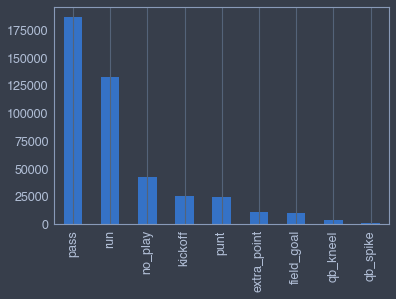

In [10]:
df['play_type'].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

In [11]:
play_type = ['run', 'pass']

df = df[df.play_type.isin(play_type)]
print('Размер выборки: ', df.shape)
df.head()

Размер выборки:  (319369, 48)


,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,short,left,-3.0,8.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,NaN,NaN,right,end,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,deep,right,34.0,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,short,left,3.0,1.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319369 entries, 1 to 449368
Data columns (total 48 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     319369 non-null  int64  
 1   game_id                     319369 non-null  int64  
 2   posteam                     319369 non-null  object 
 3   posteam_type                319369 non-null  object 
 4   defteam                     319369 non-null  object 
 5   yardline_100                319369 non-null  float64
 6   half_seconds_remaining      319352 non-null  float64
 7   game_seconds_remaining      319355 non-null  float64
 8   game_date                   319369 non-null  object 
 9   drive                       319369 non-null  int64  
 10  qtr                         319369 non-null  int64  
 11  down                        318691 non-null  float64
 12  yrdln                       319369 non-null  object 
 13  ydstogo       

In [13]:
df['play_type'].value_counts(normalize=True)

pass    0.584518
run     0.415482
Name: play_type, dtype: float64

In [14]:
df['rush_attempt'].value_counts(normalize=True)

0.0    0.584518
1.0    0.415482
Name: rush_attempt, dtype: float64

## Null/Nan Cleaning

In [15]:
df.isnull().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining            17
game_seconds_remaining            14
game_date                          0
drive                              0
qtr                                0
down                             678
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                     210
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   145506
pass_location                 145506
air_yards                     145210
yards_after_catch             210463
run_location                  188062
run_gap                       224448
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
p

### Time to end

In [16]:
df[df.half_seconds_remaining.isnull()]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
409271,895,2018090911,DEN,home,SEA,57.0,NaN,2800.0,2018-09-09,7,1,2.0,DEN 43,3,run,0.0,0,0,0,NaN,NaN,NaN,NaN,left,guard,3.0,3.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,41,(1:40) R.Freeman left guard to DEN 43 for no g...
411853,2595,2018091602,MIN,away,GB,57.0,NaN,NaN,2018-09-16,15,3,1.0,MIN 43,10,pass,20.0,0,0,0,deep,right,16.0,4.0,NaN,NaN,3.0,2.0,7.0,19.0,-12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,71,(1:40) K.Cousins pass deep right to A.Thielen ...
413083,2920,2018091700,CHI,home,SEA,35.0,NaN,NaN,2018-09-17,16,3,1.0,SEA 35,10,run,4.0,0,0,1,NaN,NaN,NaN,NaN,right,end,3.0,2.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66,(1:40) M.Trubisky scrambles right end to SEA 3...
415493,789,2018092311,CHI,away,ARI,75.0,NaN,2800.0,2018-09-23,6,1,1.0,CHI 25,10,run,7.0,1,0,0,NaN,NaN,NaN,NaN,left,end,3.0,3.0,0.0,14.0,-14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,26,(1:40) (Shotgun) T.Cohen left end pushed ob at...
415579,2864,2018092311,CHI,away,ARI,22.0,NaN,NaN,2018-09-23,17,3,2.0,ARI 22,7,pass,0.0,1,0,0,deep,right,22.0,NaN,NaN,NaN,2.0,3.0,10.0,14.0,-4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,21,(1:40) (Shotgun) M.Trubisky pass incomplete de...
416838,3405,2018093004,HOU,away,IND,79.0,NaN,NaN,2018-09-30,20,3,1.0,HOU 21,10,run,5.0,1,0,0,NaN,NaN,NaN,NaN,middle,NaN,2.0,3.0,27.0,17.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35,(1:40) (Shotgun) L.Miller up the middle to HOU...
417934,3257,2018093009,CLE,away,OAK,79.0,NaN,NaN,2018-09-30,22,3,3.0,CLE 21,9,pass,0.0,1,0,0,short,left,1.0,NaN,NaN,NaN,3.0,3.0,28.0,20.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,(1:40) (Shotgun) B.Mayfield pass incomplete sh...
423353,3028,2018101409,DEN,home,LA,22.0,NaN,NaN,2018-10-14,17,3,1.0,LA 22,20,pass,22.0,1,0,0,short,middle,14.0,8.0,NaN,NaN,3.0,3.0,3.0,20.0,-17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,12,(1:40) (Shotgun) C.Keenum pass short middle to...
423774,906,2018101412,NE,home,KC,45.0,NaN,2800.0,2018-10-14,7,1,1.0,KC 45,10,run,2.0,0,0,0,NaN,NaN,NaN,NaN,right,guard,3.0,3.0,10.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,75,(1:40) K.Barner right guard to KC 43 for 2 yar...
425695,740,2018102101,BAL,home,NO,50.0,NaN,2800.0,2018-10-21,2,1,2.0,MID 50,10,run,-2.0,1,1,0,NaN,NaN,NaN,NaN,right,end,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43,"(1:40) (No Huddle, Shotgun) A.Collins right en..."


In [17]:
df[df.game_seconds_remaining.isnull()]

##судя по всему, розыгрыши с id 1795, 610, 1541, 1632, 597, 649 были проведены в очень редком для НФЛ овертайме. Или же, у нас какая-то ошибка в заполнение. 
#Проверим игру Los Angeles Chargers c Los Angeles Rams от 2018-09-23
#Итак, это третья игровая неделя. Финальный счет 23-35, никакого овертайма

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
411853,2595,2018091602,MIN,away,GB,57.0,NaN,NaN,2018-09-16,15,3,1.0,MIN 43,10,pass,20.0,0,0,0,deep,right,16.0,4.0,NaN,NaN,3.0,2.0,7.0,19.0,-12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,71,(1:40) K.Cousins pass deep right to A.Thielen ...
413083,2920,2018091700,CHI,home,SEA,35.0,NaN,NaN,2018-09-17,16,3,1.0,SEA 35,10,run,4.0,0,0,1,NaN,NaN,NaN,NaN,right,end,3.0,2.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66,(1:40) M.Trubisky scrambles right end to SEA 3...
415188,1795,2018092310,LAC,away,LA,11.0,200.0,NaN,2018-09-23,9,2,1.0,LA 11,10,run,11.0,0,0,0,NaN,NaN,NaN,NaN,left,end,2.0,1.0,6.0,20.0,-14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,75,"(3:20) M.Gordon left end for 11 yards, TOUCHDOWN."
415579,2864,2018092311,CHI,away,ARI,22.0,NaN,NaN,2018-09-23,17,3,2.0,ARI 22,7,pass,0.0,1,0,0,deep,right,22.0,NaN,NaN,NaN,2.0,3.0,10.0,14.0,-4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,21,(1:40) (Shotgun) M.Trubisky pass incomplete de...
416838,3405,2018093004,HOU,away,IND,79.0,NaN,NaN,2018-09-30,20,3,1.0,HOU 21,10,run,5.0,1,0,0,NaN,NaN,NaN,NaN,middle,NaN,2.0,3.0,27.0,17.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35,(1:40) (Shotgun) L.Miller up the middle to HOU...
417934,3257,2018093009,CLE,away,OAK,79.0,NaN,NaN,2018-09-30,22,3,3.0,CLE 21,9,pass,0.0,1,0,0,short,left,1.0,NaN,NaN,NaN,3.0,3.0,28.0,20.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,(1:40) (Shotgun) B.Mayfield pass incomplete sh...
418065,610,2018093011,NO,away,NYG,48.0,1200.0,NaN,2018-09-30,3,1,3.0,NYG 48,1,run,2.0,0,0,0,NaN,NaN,NaN,NaN,left,end,3.0,3.0,0.0,7.0,-7.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51,(5:00) A.Kamara left end to NYG 46 for 2 yards...
418632,1541,2018100100,KC,away,DEN,66.0,200.0,NaN,2018-10-01,8,2,1.0,KC 34,23,pass,0.0,1,0,0,short,middle,11.0,NaN,NaN,NaN,2.0,3.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12,(3:20) (Shotgun) P.Mahomes pass incomplete sho...
422218,1632,2018101406,NYJ,home,IND,10.0,200.0,NaN,2018-10-14,11,2,1.0,IND 10,10,run,3.0,1,0,0,NaN,NaN,NaN,NaN,left,end,3.0,3.0,9.0,13.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43,(3:20) (Shotgun) I.Crowell left end pushed ob ...
423353,3028,2018101409,DEN,home,LA,22.0,NaN,NaN,2018-10-14,17,3,1.0,LA 22,20,pass,22.0,1,0,0,short,middle,14.0,8.0,NaN,NaN,3.0,3.0,3.0,20.0,-17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,12,(1:40) (Shotgun) C.Keenum pass short middle to...


In [18]:
#я думаю, можно удалить строки, где у нас со временем беда
#их не так много по сравнению со всем датасетом, так что не думаю, что они сильно повлияют на конечный результат

df = df[pd.notnull(df['half_seconds_remaining'])]
df.head()

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,short,left,-3.0,8.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,NaN,NaN,right,end,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,deep,right,34.0,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,short,left,3.0,1.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...


In [19]:
df = df[pd.notnull(df['game_seconds_remaining'])]
df.head()

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,short,left,-3.0,8.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,NaN,NaN,right,end,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,deep,right,34.0,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,short,left,3.0,1.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...


### Number of Down

In [20]:
df[df.down.isnull()]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
996,2996,2009091306,JAC,away,IND,2.0,667.0,667.0,2009-09-13,15,4,NaN,IND 2,0,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,12.0,14.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,58,TWO-POINT CONVERSION ATTEMPT. M.Jones-Drew rus...
1181,3721,2009091303,DEN,away,CIN,2.0,11.0,11.0,2009-09-13,21,4,NaN,CIN 2,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,12.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,87,(Pass formation) TWO-POINT CONVERSION ATTEMPT....
2383,3768,2009091312,GB,home,CHI,2.0,71.0,71.0,2009-09-13,24,4,NaN,CHI 2,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,19.0,15.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,72,TWO-POINT CONVERSION ATTEMPT. A.Rodgers pass t...
2544,3778,2009091400,NE,home,BUF,2.0,126.0,126.0,2009-09-14,16,4,NaN,BUF 2,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,19.0,23.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,81,TWO-POINT CONVERSION ATTEMPT. T.Brady pass to ...
2549,3918,2009091400,NE,home,BUF,2.0,50.0,50.0,2009-09-14,18,4,NaN,BUF 2,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,25.0,23.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,31,TWO-POINT CONVERSION ATTEMPT. T.Brady pass to ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447224,2786,2018121603,GB,away,CHI,2.0,1150.0,1150.0,2018-12-16,13,3,NaN,CHI 2,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,12.0,14.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,50,TWO-POINT CONVERSION ATTEMPT. A.Rodgers pass t...
447332,1020,2018121602,DET,away,BUF,15.0,645.0,2445.0,2018-12-16,4,2,NaN,BUF 15,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,75,(Kick formation) TWO-POINT CONVERSION ATTEMPT....
447502,1136,2018121601,TB,away,BAL,15.0,728.0,2528.0,2018-12-16,7,2,NaN,BAL 15,0,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51,(Kick formation) TWO-POINT CONVERSION ATTEMPT....
447714,2332,2018121600,ATL,home,ARI,2.0,13.0,1813.0,2018-12-16,14,2,NaN,ARI 2,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,25.0,7.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,71,(Pass formation) TWO-POINT CONVERSION ATTEMPT....


In [21]:
##ага, сперва решил посмотреть на эти розыгрыши, когда нет дауна, но все же играют пас/вынос. Посмотрев на дистанцию, понял, что это двухочковые реализации после тачдауна
##это потвердило описание розыгрыша после того как я вывел его в конец таблицы, чтобы была возможность посмотреть-почитать
##остались вопросы по розыгрышам с 7,  99, 3 ярдов

df[df.down.isnull()]['yardline_100'].value_counts()

2.0     616
1.0      35
7.0      14
15.0     11
99.0      1
3.0       1
Name: yardline_100, dtype: int64

In [22]:
# ох, двухочковая с 99 ярдов от Нейтена Питермана (sic)
# что же это за розыгрыш такой

#в итоге просто ошибка в данных. играл он с 1 ярда 

df[(df.down.isnull()) & (df.yardline_100 == 99)]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
429313,4346,2018110401,BUF,home,CHI,99.0,341.0,341.0,2018-11-04,23,4,NaN,BUF 1,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,9.0,32.0,-23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,75,TWO-POINT CONVERSION ATTEMPT. N.Peterman pass ...


In [23]:
df.loc[(df.posteam == 'BUF') & (df.drive == 23) & (df.game_date == '2018-11-04') & (df.yardline_100 == 99), 'yardline_100'] = 1

In [24]:
df[df.down.isnull()]['yardline_100'].value_counts()

2.0     616
1.0      36
7.0      14
15.0     11
3.0       1
Name: yardline_100, dtype: int64

In [25]:
##ага, все норм теперь
df[(df.down.isnull()) & (df.yardline_100 == 1)]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
10762,3571,2009100500,GB,away,MIN,1.0,220.0,220.0,2009-10-05,18,4,NaN,MIN 1,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,19.0,30.0,-11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,96,TWO-POINT CONVERSION ATTEMPT. A.Rodgers pass t...
62780,4080,2010102500,DAL,home,NYG,1.0,197.0,197.0,2010-10-25,28,4,NaN,NYG 1,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,25.0,38.0,-13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15,(Pass formation) TWO-POINT CONVERSION ATTEMPT....
65776,3141,2010110703,SD,away,HOU,1.0,317.0,317.0,2010-11-07,17,4,NaN,HOU 1,0,run,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,27.0,23.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,65,TWO-POINT CONVERSION ATTEMPT. M.Tolbert rushes...
69770,4262,2010111411,PIT,home,NE,1.0,179.0,179.0,2010-11-14,22,4,NaN,NE 1,0,run,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,24.0,36.0,-12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,80,TWO-POINT CONVERSION ATTEMPT. M.Moore rushes r...
82895,3740,2010121905,WAS,away,DAL,1.0,457.0,457.0,2010-12-19,19,4,NaN,DAL 1,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,28.0,30.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,56,TWO-POINT CONVERSION ATTEMPT. R.Grossman pass ...
83076,3475,2010121910,SEA,home,ATL,1.0,509.0,509.0,2010-12-19,18,4,NaN,ATL 1,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,16.0,33.0,-17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,88,TWO-POINT CONVERSION ATTEMPT. C.Whitehurst pas...
95804,3166,2011092505,NYG,away,PHI,1.0,487.0,487.0,2011-09-25,16,4,NaN,PHI 1,0,run,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,20.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54,(Run formation) TWO-POINT CONVERSION ATTEMPT. ...
133305,3028,2012010110,TB,away,ATL,1.0,673.0,673.0,2012-01-01,18,4,NaN,ATL 1,0,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,22.0,41.0,-19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,77,(Pass formation) TWO-POINT CONVERSION ATTEMPT....
204978,4238,2013111002,CHI,home,DET,1.0,40.0,40.0,2013-11-10,22,4,NaN,DET 1,0,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,19.0,21.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,74,#62 E. Britton reports eligible. (Run formatio...
214343,3396,2013120802,NE,home,CLE,1.0,906.0,906.0,2013-12-08,19,3,NaN,CLE 1,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,9.0,19.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,72,TWO-POINT CONVERSION ATTEMPT. T.Brady pass to ...


In [26]:
df.down.fillna(0, inplace=True)

In [27]:
df.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                     210
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   145492
pass_location                 145492
air_yards                     145196
yards_after_catch             210446
run_location                  188053
run_gap                       224436
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
p

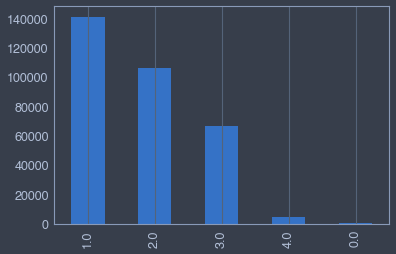

In [28]:
df['down'].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

### Yards Gained

In [29]:
df['yards_gained'].value_counts()

 0.0     80219
 2.0     21094
 3.0     20406
 4.0     19048
 1.0     18229
         ...  
 98.0        2
 93.0        2
-38.0        1
-26.0        1
-27.0        1
Name: yards_gained, Length: 127, dtype: int64

In [30]:
df[df.yards_gained.isna()]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
209596,58,2013112401,PIT,away,CLE,74.0,1795.0,3595.0,2013-11-24,1,1,1.0,PIT 26,10,pass,NaN,0,0,0,short,right,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,45,(14:55) B.Roethlisberger pass short right to E...
209597,90,2013112401,PIT,away,CLE,60.0,1770.0,3570.0,2013-11-24,1,1,1.0,PIT 40,10,run,NaN,1,1,0,NaN,NaN,NaN,NaN,left,tackle,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,"(14:30) (No Huddle, Shotgun) L.Bell left tackl..."
209598,111,2013112401,PIT,away,CLE,58.0,1733.0,3533.0,2013-11-24,1,1,2.0,PIT 42,8,run,NaN,0,1,0,NaN,NaN,NaN,NaN,right,guard,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,(13:53) (No Huddle) L.Bell right guard to CLE ...
209599,132,2013112401,PIT,away,CLE,45.0,1696.0,3496.0,2013-11-24,1,1,1.0,CLE 45,10,run,NaN,1,1,0,NaN,NaN,NaN,NaN,right,guard,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,"(13:16) (No Huddle, Shotgun) L.Bell right guar..."
209600,153,2013112401,PIT,away,CLE,43.0,1658.0,3458.0,2013-11-24,1,1,2.0,CLE 43,8,pass,NaN,1,1,0,short,middle,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,45,"(12:38) (No Huddle, Shotgun) B.Roethlisberger ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211881,4378,2013120101,JAC,away,CLE,21.0,88.0,88.0,2013-12-01,27,4,1.0,CLE 21,10,pass,NaN,1,0,0,short,left,NaN,NaN,NaN,NaN,3.0,3.0,25.0,28.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,80,(1:28) (Shotgun) C.Henne pass short left to A....
211883,4428,2013120101,JAC,away,CLE,20.0,45.0,45.0,2013-12-01,27,4,3.0,CLE 20,9,pass,NaN,1,0,0,short,left,NaN,NaN,NaN,NaN,3.0,3.0,25.0,28.0,-3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,80,(:45) (Shotgun) C.Henne pass short left to C.S...
211888,4527,2013120101,CLE,home,JAC,80.0,30.0,30.0,2013-12-01,28,4,3.0,CLE 20,10,pass,NaN,1,0,0,short,left,NaN,NaN,NaN,NaN,3.0,3.0,28.0,32.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,28,(:30) (Shotgun) B.Weeden pass short left to G....
211889,4551,2013120101,CLE,home,JAC,75.0,22.0,22.0,2013-12-01,28,4,4.0,CLE 25,5,pass,NaN,1,0,0,short,left,NaN,NaN,NaN,NaN,3.0,3.0,28.0,32.0,-4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,28,(:22) (Shotgun) B.Weeden pass short left to D....


In [31]:
## ну тут явно косяк в заполнении, причем не хватает вообще практически все информации по розыгрышу, так что либо править вручную, либо удалять
## я выбрал удалять
df = df[pd.notnull(df['yards_gained'])]

df.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                       0
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   145376
pass_location                 145376
air_yards                     144986
yards_after_catch             210236
run_location                  187948
run_gap                       224320
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
p

### Run Plays

In [32]:
#начнем пожалуй с run_location 
df['play_type'].value_counts()

pass    186564
run     132572
Name: play_type, dtype: int64

In [33]:
df['run_location'].value_counts()

left      47643
right     47173
middle    36372
Name: run_location, dtype: int64

In [34]:
#так, куда делись еще ≈1400 розыгрышей
df[(df.run_location.isnull()) & (df.play_type == 'run') & (df.fumble == 1)]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
648,2653,2009091308,TB,home,DAL,72.0,1078.0,1078.0,2009-09-13,17,3,1.0,TB 28,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,7.0,20.0,-13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,9,"(2:58) B.Leftwich FUMBLES (Aborted) at TB 28, ..."
731,698,2009091305,NYJ,away,HOU,26.0,1087.0,2887.0,2009-09-13,4,1,1.0,HOU 26,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68,"(3:07) M.Sanchez FUMBLES (Aborted) at HOU 26, ..."
1056,742,2009091303,CIN,home,DEN,10.0,1011.0,2811.0,2009-09-13,4,1,4.0,DEN 10,2,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,6,(1:51) (Field Goal formation) K.Huber FUMBLES ...
1303,2833,2009091302,PHI,away,CAR,61.0,1257.0,1257.0,2009-09-13,18,3,1.0,PHI 39,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,36.0,10.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,16,"(5:57) K.Kolb FUMBLES (Aborted) at PHI 39, bal..."
2069,89,2009091310,NYG,home,WAS,75.0,1770.0,3570.0,2009-09-13,1,1,2.0,NYG 25,7,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,7,"(14:30) E.Manning FUMBLES (Aborted) at NYG 25,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445149,3928,2018120903,ATL,away,GB,8.0,409.0,409.0,2018-12-09,17,4,2.0,GB 8,8,run,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,14.0,33.0,-19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,53,(6:49) (Shotgun) M.Ryan Aborted. A.Mack FUMBLE...
446219,4394,2018120912,DAL,home,PHI,41.0,21.0,21.0,2018-12-09,23,4,2.0,PHI 41,6,run,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,23.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,26,(:21) (Shotgun) D.Prescott Aborted. J.Looney F...
446667,2069,2018121300,KC,home,LAC,74.0,1795.0,1795.0,2018-12-13,10,3,1.0,KC 26,10,run,-3.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,14.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,74,(14:55) (Shotgun) P.Mahomes to KC 18 for -8 ya...
447237,3110,2018121603,CHI,home,GB,23.0,863.0,863.0,2018-12-16,14,4,3.0,GB 23,1,run,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,14.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,49,(14:23) (Shotgun) Direct snap to T.Cohen. T.C...


In [35]:
#df_rp = df_rp[pd.notnull(df_rp['run_location'])]
df = df[((df.run_location.notnull()) & (df.play_type == 'run') | (df.play_type == 'pass'))]
df.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                       0
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   143992
pass_location                 143992
air_yards                     143602
yards_after_catch             208852
run_location                  186564
run_gap                       222941
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
p

In [36]:
df['run_location'].value_counts()

left      47643
right     47173
middle    36372
Name: run_location, dtype: int64

In [37]:
df['run_gap'].value_counts()

end       32290
tackle    32183
guard     30338
Name: run_gap, dtype: int64

In [38]:
# не, ну так то все нормально с розыгрышами, просто нет обозначения для прохода по центру
df[(df.run_gap.isnull()) & (df.play_type == 'run')]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...
21,542,2009091000,PIT,home,TEN,73.0,1304.0,3104.0,2009-09-10,5,1,1.0,PIT 27,10,run,1.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,(6:44) R.Mendenhall up the middle to PIT 28 fo...
22,563,2009091000,PIT,home,TEN,72.0,1269.0,3069.0,2009-09-10,5,1,2.0,PIT 28,9,run,2.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,(6:09) R.Mendenhall up the middle to PIT 30 fo...
35,868,2009091000,TEN,away,PIT,44.0,906.0,2706.0,2009-09-10,8,1,1.0,PIT 44,10,run,1.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,(:06) C.Johnson up the middle to PIT 43 for 1 ...
54,1330,2009091000,TEN,away,PIT,73.0,427.0,2227.0,2009-09-10,10,2,2.0,TEN 27,10,run,4.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,(7:07) L.White up the middle to TEN 31 for 4 y...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449293,2210,2018121700,NO,away,CAR,61.0,1712.0,1712.0,2018-12-17,13,3,1.0,NO 39,10,run,0.0,1,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,6.0,7.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14,(13:32) (Shotgun) M.Ingram up the middle to NO...
449312,2723,2018121700,CAR,home,NO,73.0,1320.0,1320.0,2018-12-17,16,3,1.0,CAR 27,10,run,2.0,1,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,2.0,7.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57,(7:00) (Shotgun) C.McCaffrey up the middle to ...
449318,2861,2018121700,CAR,home,NO,50.0,1115.0,1115.0,2018-12-17,16,3,1.0,MID 50,10,run,22.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,2.0,7.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,57,(3:35) D.Moore up the middle to NO 28 for 22 y...
449324,3052,2018121700,NO,away,CAR,54.0,955.0,955.0,2018-12-17,17,3,2.0,NO 46,1,run,1.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,2.0,3.0,6.0,7.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,84,(:55) Z.Line up the middle to NO 47 for 1 yard...


In [39]:
# но я же люблю амфут, так что буду дотошным
# пффф, ну с восьмю розыграшами я разберусь
df[(df.run_gap.isnull()) & (df.play_type == 'run') & (df.run_location != 'middle')]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
6433,3895,2009092704,MIN,home,SF,52.0,136.0,136.0,2009-09-27,25,4,1.0,MIN 48,10,run,1.0,0,0,0,NaN,NaN,NaN,NaN,right,NaN,3.0,1.0,20.0,23.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25,(2:16) B.Favre pass deep right to S.Rice pushe...
48917,79,2010091910,STL,away,OAK,73.0,1774.0,3574.0,2010-09-19,1,1,2.0,STL 27,8,run,-2.0,0,0,0,short,right,7.0,6.0,right,NaN,3.0,3.0,0.0,2.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-1,(14:34) S.Bradford pass short right to B.Bajem...
53483,1126,2010100303,DEN,away,TEN,22.0,744.0,2544.0,2010-10-03,8,2,1.0,TEN 22,10,run,17.0,0,0,0,short,left,0.0,17.0,left,NaN,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,63,(12:24) K.Orton pass short left to E.Royal to ...
98119,3719,2011100201,CLE,home,TEN,40.0,291.0,291.0,2011-10-02,22,4,2.0,TEN 40,10,run,1.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,13.0,30.0,-17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,(4:51) (Shotgun) C.McCoy pass deep left to M.M...
136275,2436,2012090910,SEA,away,ARI,75.0,1568.0,1568.0,2012-09-09,11,3,1.0,SEA 25,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,3.0,10.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,(11:08) R.Wilson pass incomplete short left to...
171739,1690,2012121607,HOU,home,IND,13.0,287.0,2087.0,2012-12-16,9,2,2.0,IND 13,10,run,-4.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63,"(4:47) B.Tate left end, dead ball declared at ..."
195590,3718,2013101310,NO,away,NE,81.0,509.0,509.0,2013-10-13,20,4,1.0,NO 19,10,run,16.0,0,0,1,NaN,NaN,NaN,NaN,left,NaN,2.0,3.0,17.0,23.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16,"(8:29) D.Brees scrambles left end, dead ball d..."
231986,3155,2014092102,CLE,home,BAL,16.0,482.0,482.0,2014-09-21,15,4,3.0,BAL 16,16,run,3.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,2.0,21.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61,(8:02) (Shotgun) B.Hoyer to BAL 13 for 3 yards...


Пожалуй, пойдем по порядку:
<pd>
1. Игра San Francisco 49ers против Minnesota Vikings. Конец игры, осталось совсем немного времени. Минесота в нападение и у них первый даун. В таблице выносной розыгрыш и есть нарушение от Бретта Фарва. Скорей всего, он выбежал за линию скримеджа и попытался сделать пас, но давайте посмотрим записи игры
    
##я пытался найти видео или хотя бы фотку розыгрыша, но так и не нашел. но я был прав, там действительно именно это нарушение. 

  Да, все верно. Такой розыгрыш можно дропнуть

In [40]:
df.drop(6433, inplace=True)

df[(df.run_gap.isnull()) & (df.play_type == 'run') & (df.run_location != 'middle')]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
48917,79,2010091910,STL,away,OAK,73.0,1774.0,3574.0,2010-09-19,1,1,2.0,STL 27,8,run,-2.0,0,0,0,short,right,7.0,6.0,right,NaN,3.0,3.0,0.0,2.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-1,(14:34) S.Bradford pass short right to B.Bajem...
53483,1126,2010100303,DEN,away,TEN,22.0,744.0,2544.0,2010-10-03,8,2,1.0,TEN 22,10,run,17.0,0,0,0,short,left,0.0,17.0,left,NaN,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,63,(12:24) K.Orton pass short left to E.Royal to ...
98119,3719,2011100201,CLE,home,TEN,40.0,291.0,291.0,2011-10-02,22,4,2.0,TEN 40,10,run,1.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,13.0,30.0,-17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,(4:51) (Shotgun) C.McCoy pass deep left to M.M...
136275,2436,2012090910,SEA,away,ARI,75.0,1568.0,1568.0,2012-09-09,11,3,1.0,SEA 25,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,3.0,10.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,(11:08) R.Wilson pass incomplete short left to...
171739,1690,2012121607,HOU,home,IND,13.0,287.0,2087.0,2012-12-16,9,2,2.0,IND 13,10,run,-4.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63,"(4:47) B.Tate left end, dead ball declared at ..."
195590,3718,2013101310,NO,away,NE,81.0,509.0,509.0,2013-10-13,20,4,1.0,NO 19,10,run,16.0,0,0,1,NaN,NaN,NaN,NaN,left,NaN,2.0,3.0,17.0,23.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16,"(8:29) D.Brees scrambles left end, dead ball d..."
231986,3155,2014092102,CLE,home,BAL,16.0,482.0,482.0,2014-09-21,15,4,3.0,BAL 16,16,run,3.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,2.0,21.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61,(8:02) (Shotgun) B.Hoyer to BAL 13 for 3 yards...


In [41]:
## окей, следующий розыгрыш от Сэма Бредфорда и в описании это пас, так что изменим тип розыгрыша и удалим run_location
df.loc[((df.play_id == 79) & (df.game_id == 2010091910)), 'play_type'] = 'pass'
df.loc[((df.play_id == 79) & (df.game_id == 2010091910)), 'run_location'] = np.nan
df.loc[((df.play_id == 79) & (df.game_id == 2010091910)), 'rush_attempt'] = 0

df[(df.play_id == 79) & (df.game_id == 2010091910)]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
48917,79,2010091910,STL,away,OAK,73.0,1774.0,3574.0,2010-09-19,1,1,2.0,STL 27,8,pass,-2.0,0,0,0,short,right,7.0,6.0,NaN,NaN,3.0,3.0,0.0,2.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1,(14:34) S.Bradford pass short right to B.Bajem...


In [42]:
df[(df.run_gap.isnull()) & (df.play_type == 'run') & (df.run_location != 'middle')]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
53483,1126,2010100303,DEN,away,TEN,22.0,744.0,2544.0,2010-10-03,8,2,1.0,TEN 22,10,run,17.0,0,0,0,short,left,0.0,17.0,left,NaN,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,63,(12:24) K.Orton pass short left to E.Royal to ...
98119,3719,2011100201,CLE,home,TEN,40.0,291.0,291.0,2011-10-02,22,4,2.0,TEN 40,10,run,1.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,13.0,30.0,-17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,(4:51) (Shotgun) C.McCoy pass deep left to M.M...
136275,2436,2012090910,SEA,away,ARI,75.0,1568.0,1568.0,2012-09-09,11,3,1.0,SEA 25,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,3.0,10.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,(11:08) R.Wilson pass incomplete short left to...
171739,1690,2012121607,HOU,home,IND,13.0,287.0,2087.0,2012-12-16,9,2,2.0,IND 13,10,run,-4.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63,"(4:47) B.Tate left end, dead ball declared at ..."
195590,3718,2013101310,NO,away,NE,81.0,509.0,509.0,2013-10-13,20,4,1.0,NO 19,10,run,16.0,0,0,1,NaN,NaN,NaN,NaN,left,NaN,2.0,3.0,17.0,23.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16,"(8:29) D.Brees scrambles left end, dead ball d..."
231986,3155,2014092102,CLE,home,BAL,16.0,482.0,482.0,2014-09-21,15,4,3.0,BAL 16,16,run,3.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,2.0,21.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61,(8:02) (Shotgun) B.Hoyer to BAL 13 for 3 yards...


In [43]:
df.loc[((df.play_id == 1126) & (df.game_id == 2010100303)), 'play_type'] = 'pass'
df.loc[((df.play_id == 1126) & (df.game_id == 2010100303)), 'run_location'] = np.nan
df.loc[((df.play_id == 1126) & (df.game_id == 2010100303)), 'rush_attempt'] = 0

df[(df.play_id == 1126) & (df.game_id == 2010100303)]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
53483,1126,2010100303,DEN,away,TEN,22.0,744.0,2544.0,2010-10-03,8,2,1.0,TEN 22,10,pass,17.0,0,0,0,short,left,0.0,17.0,NaN,NaN,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,63,(12:24) K.Orton pass short left to E.Royal to ...


In [44]:
df[(df.run_gap.isnull()) & (df.play_type == 'run') & (df.run_location != 'middle')]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
98119,3719,2011100201,CLE,home,TEN,40.0,291.0,291.0,2011-10-02,22,4,2.0,TEN 40,10,run,1.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,13.0,30.0,-17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,(4:51) (Shotgun) C.McCoy pass deep left to M.M...
136275,2436,2012090910,SEA,away,ARI,75.0,1568.0,1568.0,2012-09-09,11,3,1.0,SEA 25,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,3.0,10.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,(11:08) R.Wilson pass incomplete short left to...
171739,1690,2012121607,HOU,home,IND,13.0,287.0,2087.0,2012-12-16,9,2,2.0,IND 13,10,run,-4.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63,"(4:47) B.Tate left end, dead ball declared at ..."
195590,3718,2013101310,NO,away,NE,81.0,509.0,509.0,2013-10-13,20,4,1.0,NO 19,10,run,16.0,0,0,1,NaN,NaN,NaN,NaN,left,NaN,2.0,3.0,17.0,23.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16,"(8:29) D.Brees scrambles left end, dead ball d..."
231986,3155,2014092102,CLE,home,BAL,16.0,482.0,482.0,2014-09-21,15,4,3.0,BAL 16,16,run,3.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,2.0,21.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61,(8:02) (Shotgun) B.Hoyer to BAL 13 for 3 yards...


In [45]:
df.drop(98119, inplace=True)
df.drop(136275, inplace=True)

df[(df.run_gap.isnull()) & (df.play_type == 'run') & (df.run_location != 'middle')]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
171739,1690,2012121607,HOU,home,IND,13.0,287.0,2087.0,2012-12-16,9,2,2.0,IND 13,10,run,-4.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63,"(4:47) B.Tate left end, dead ball declared at ..."
195590,3718,2013101310,NO,away,NE,81.0,509.0,509.0,2013-10-13,20,4,1.0,NO 19,10,run,16.0,0,0,1,NaN,NaN,NaN,NaN,left,NaN,2.0,3.0,17.0,23.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16,"(8:29) D.Brees scrambles left end, dead ball d..."
231986,3155,2014092102,CLE,home,BAL,16.0,482.0,482.0,2014-09-21,15,4,3.0,BAL 16,16,run,3.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,2.0,21.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61,(8:02) (Shotgun) B.Hoyer to BAL 13 for 3 yards...


In [46]:
df.loc[((df.play_id == 1690) & (df.game_id == 2012121607)), 'run_gap'] = 'end'

In [47]:
df.loc[((df.play_id == 3718) & (df.game_id == 2013101310)), 'run_gap'] = 'end'

In [48]:
df.drop(231986, inplace=True)

In [49]:
df.loc[(df.run_gap.isnull()) & (df.play_type == 'run') & (df.run_location == 'middle'),'run_gap'] = 'center'

In [50]:
df.run_gap.value_counts()

center    36369
end       32292
tackle    32183
guard     30338
Name: run_gap, dtype: int64

In [51]:
df.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                       0
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   143988
pass_location                 143988
air_yards                     143598
yards_after_catch             208848
run_location                  186566
run_gap                       186566
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
p

In [52]:
# Сделали OHE для категориальных переменных
df_run_gap = pd.get_dummies(df['run_gap'], prefix='run_gap')
df_run_loc = pd.get_dummies(df['run_location'], prefix='run_loc')

# Объединили назад наши таблички
df = pd.concat([df.drop('run_gap',axis=1),df_run_gap], axis=1)
df = pd.concat([df.drop('run_location',axis=1),df_run_loc], axis=1)

print('Размер выборки: ', df.shape)
df.head()

Размер выборки:  (317748, 53)


,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc,run_gap_center,run_gap_end,run_gap_guard,run_gap_tackle,run_loc_left,run_loc_middle,run_loc_right
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,short,left,-3.0,8.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....,0,0,0,0,0,0,0
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...,0,1,0,0,0,0,1
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,deep,right,34.0,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...,0,0,0,0,0,0,0
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...,1,0,0,0,0,1,0
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,short,left,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...,0,0,0,0,0,0,0


In [53]:
df.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                       0
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   143988
pass_location                 143988
air_yards                     143598
yards_after_catch             208848
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
posteam_score                      0
defteam_score                      0
s

In [54]:
df.to_csv('data/run cleaned.csv', encoding='utf-8', index=False)

### Pass Plays

In [55]:
df.pass_location.value_counts()

right     70062
left      62872
middle    40826
Name: pass_location, dtype: int64

In [56]:
#категориальные данные - делаем OHE
df_pass_loc = pd.get_dummies(df['pass_location'], prefix='pass_loc')

# Объединили назад наши таблички
df = pd.concat([df.drop('pass_location',axis=1),df_pass_loc], axis=1)

In [57]:
df.pass_length.value_counts()

short    141457
deep      32303
Name: pass_length, dtype: int64

In [58]:
#категориальные данные - делаем OHE
df_pass_len = pd.get_dummies(df['pass_length'], prefix='pass_len')

# Объединили назад наши таблички
df = pd.concat([df.drop('pass_length',axis=1),df_pass_len], axis=1)

In [59]:
df.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                       0
shotgun                            0
no_huddle                          0
qb_scramble                        0
air_yards                     143598
yards_after_catch             208848
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
posteam_score                      0
defteam_score                      0
score_differential                 0
first_down_rush                    0
f

In [60]:
print('Размер выборки: ', df.shape)
df.head()

Размер выборки:  (317748, 56)


,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,air_yards,yards_after_catch,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc,run_gap_center,run_gap_end,run_gap_guard,run_gap_tackle,run_loc_left,run_loc_middle,run_loc_right,pass_loc_left,pass_loc_middle,pass_loc_right,pass_len_deep,pass_len_short
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,-3.0,8.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....,0,0,0,0,0,0,0,1,0,0,0,1
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...,0,1,0,0,0,0,1,0,0,0,0,0
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,34.0,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...,0,0,0,0,0,0,0,0,0,1,1,0
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...,1,0,0,0,0,1,0,0,0,0,0,0
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...,0,0,0,0,0,0,0,1,0,0,0,1


In [61]:
df[(df.air_yards.isnull()) & (df.play_type == 'pass') & (df.sack != 1) & (df.incomplete_pass == 1)]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,air_yards,yards_after_catch,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc,run_gap_center,run_gap_end,run_gap_guard,run_gap_tackle,run_loc_left,run_loc_middle,run_loc_right,pass_loc_left,pass_loc_middle,pass_loc_right,pass_len_deep,pass_len_short
1362,4221,2009091302,CAR,home,PHI,3.0,65.0,65.0,2009-09-13,27,4,1.0,PHI 3,3,pass,0.0,0,0,0,NaN,NaN,2.0,2.0,10.0,36.0,-26.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,50,(1:05) M.Moore pass incomplete right to K.Moore.,0,0,0,0,0,0,0,0,0,0,0,0
6847,1665,2009092706,PHI,home,KC,74.0,375.0,2175.0,2009-09-27,11,2,2.0,PHI 26,9,pass,0.0,1,0,0,NaN,NaN,1.0,3.0,21.0,7.0,14.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14,(6:15) #7 M. Vick in at Quarterback. (Shotgu...,0,0,0,0,0,0,0,0,0,0,0,0
6865,2077,2009092706,KC,away,PHI,65.0,19.0,1819.0,2009-09-27,12,2,2.0,KC 35,1,pass,0.0,1,0,0,NaN,NaN,2.0,1.0,7.0,24.0,-17.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,(:19) (Shotgun) M.Cassel pass incomplete left ...,0,0,0,0,0,0,0,0,0,0,0,0
15681,871,2009102506,TB,home,NE,89.0,1026.0,2826.0,2009-10-25,6,1,1.0,TB 11,10,pass,0.0,0,0,0,NaN,NaN,3.0,3.0,0.0,13.0,-13.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,(2:06) J.Johnson pass incomplete middle to K.W...,0,0,0,0,0,0,0,0,0,0,0,0
16228,1651,2009102503,KC,home,SD,63.0,148.0,1948.0,2009-10-25,10,2,2.0,KC 37,6,pass,0.0,1,0,0,NaN,NaN,3.0,2.0,0.0,17.0,-17.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4,(2:28) (Shotgun) M.Cassel pass incomplete left...,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370172,3370,2017092413,OAK,away,WAS,68.0,323.0,323.0,2017-09-24,24,4,3.0,OAK 32,3,pass,0.0,1,0,0,NaN,NaN,3.0,2.0,10.0,27.0,-17.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7,(5:23) (Shotgun) D.Carr pass incomplete right.,0,0,0,0,0,0,0,0,0,0,0,0
390856,890,2017112302,NYG,away,WAS,33.0,907.0,2707.0,2017-11-23,7,1,2.0,WAS 33,7,pass,0.0,0,0,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26,(:07) E.Manning pass incomplete right.,0,0,0,0,0,0,0,0,0,0,0,0
390955,3254,2017112302,WAS,home,NYG,45.0,662.0,662.0,2017-11-23,21,4,2.0,NYG 45,6,pass,0.0,0,0,0,NaN,NaN,3.0,3.0,10.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4,(11:02) K.Cousins pass incomplete right.,0,0,0,0,0,0,0,0,0,0,0,0
421917,2161,2018101408,WAS,home,CAR,69.0,1794.0,1794.0,2018-10-14,15,3,1.0,WAS 31,10,pass,0.0,0,0,0,NaN,NaN,3.0,3.0,17.0,6.0,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,31,(14:54) A.Smith pass incomplete right.,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
# Пожалуй эти столбцы не буду преобразовывать, а сохраню в другом датафрейме
df = df.drop(['air_yards', 'yards_after_catch'], axis = 1) 

In [63]:
df.isna().sum()

play_id                       0
game_id                       0
posteam                       0
posteam_type                  0
defteam                       0
yardline_100                  0
half_seconds_remaining        0
game_seconds_remaining        0
game_date                     0
drive                         0
qtr                           0
down                          0
yrdln                         0
ydstogo                       0
play_type                     0
yards_gained                  0
shotgun                       0
no_huddle                     0
qb_scramble                   0
posteam_timeouts_remaining    0
defteam_timeouts_remaining    0
posteam_score                 0
defteam_score                 0
score_differential            0
first_down_rush               0
first_down_pass               0
first_down_penalty            0
third_down_converted          0
fourth_down_converted         0
incomplete_pass               0
interception                  0
safety  

In [64]:
df.to_csv('data/pass cleaned.csv', encoding='utf-8', index=False)

## Changing Data

### Adding season variable

In [65]:
def split_date(row):
    season = row['game_date']
    season = season[0:4]
    return season

In [66]:
df['season'] = df.swifter.apply(split_date, axis = 1)

/Users/aleksandrbagdasarov/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [67]:
df.head()

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc,run_gap_center,run_gap_end,run_gap_guard,run_gap_tackle,run_loc_left,run_loc_middle,run_loc_right,pass_loc_left,pass_loc_middle,pass_loc_right,pass_len_deep,pass_len_short,season
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....,0,0,0,0,0,0,0,1,0,0,0,1,2009
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...,0,1,0,0,0,0,1,0,0,0,0,0,2009
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...,0,0,0,0,0,0,0,0,0,1,1,0,2009
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...,1,0,0,0,0,1,0,0,0,0,0,0,2009
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...,0,0,0,0,0,0,0,1,0,0,0,1,2009


In [68]:
df.to_csv('data/season added.csv', encoding='utf-8', index=False)

### Adding Football Outsiders data

Поскольку в исходном датасете отстутствуют такие важные данные, как исходные формации нападения и защиты, ключевой персонал и тому подобные фичи, которые могли бы нам подсказать о предстоящем розыгрыше, то я решил добавить другие данные. Ресурс Football Outsiders предлагает продвинутую статистику по многим показатателям. Возьмем статистики по рейтингам команд на выносе, пасе и в общем в защите и нападении за каждый год. 

In [ ]:
from bs4 import BeautifulSoup
import csv
import requests
import numpy as np

years = np.arange(2009, 2019).tolist()
stats = ['team-offense', 'team-defense']

for stat in stats:
    page_link = 'https://www.footballoutsiders.com/stats/nfl/' + stat + '/'
    for year in years:
        output_rows = []
        # page_link = page_link + str(year)
        print(page_link)
        csv_name = ('{} {}.csv'.format(stat, year))
        response = requests.get(page_link + str(year))
        html = response.content
        soup = BeautifulSoup(html, features="html.parser")
        table = soup.find("table")

        for table_row in table.findAll('tr'):
            columns = table_row.findAll('td')
            output_row = []
            for column in columns:
                output_row.append(column.text)
            output_rows.append(output_row)

        with open(csv_name, 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(output_rows)

In [ ]:
years = np.arange(2009,2019).tolist()

for year in years:
    csv_row = 'data/stats/team-defense ' + str(year) + '.csv'
    df_def = pd.read_csv(csv_row, sep = ';')
    df_def['Year'] = year
    df_def.to_csv(csv_row, index=False)

In [70]:
years = np.arange(2009,2019).tolist()

for year in years:
    csv_row = 'data/stats/team-offense ' + str(year) + '.csv'
    df_of = pd.read_csv(csv_row, sep = ';')
    df_of['Year'] = year
    df_of.to_csv(csv_row, index=False)

In [71]:
years = np.arange(2010, 2019).tolist()

df_def_origin = pd.read_csv('data/stats/team-defense 2009.csv', sep = ';')

for year in years:
    csv_row = 'data/stats/team-defense ' + str(year) + '.csv'
    df_def = pd.read_csv(csv_row, sep = ';')
    frames = [df_def_origin, df_def]
    df_def_origin = pd.concat(frames, ignore_index=True)

df_def_origin.to_csv('data/stats/team defense 2009-2018 backup.csv', encoding='utf-8', sep = ';', index=False)

df_of_origin = pd.read_csv('data/stats/team-offense 2009.csv')

for year in years:
    csv_row = 'data/stats/team-offense ' + str(year) + '.csv'
    df_of = pd.read_csv(csv_row)
    frames = [df_of_origin, df_of]
    df_of_origin = pd.concat(frames, ignore_index=False)

df_of_origin.to_csv('data/stats/team offense 2009-2018 backup.csv', encoding='utf-8', index=False)

In [69]:
#df_of.to_csv('data/stats/team offense 2009-2018.csv', index=False)
#df_def.to_csv('data/stats/team defense 2009-2018.csv', index=False)

df_def = pd.read_csv('data/stats/team defense 2009-2018.csv')
df_of = pd.read_csv('data/stats/team offense 2009-2018.csv')

In [70]:
df_def.head()

,TEAM,DEF. DVOA,LAST YEAR,WEIGHTED DEFENSE,WD RK,PASS DEF.,PASS RANK,RUSH DEF.,RUSH RANK,TOTAL,PASS,RUSH,VAR,VAR RK,SHED,SHED RK,Year
0,NYJ,-25.5%,14,-29.2%,1,-36.5%,1,-13.9%,7,-24.9%,-34.9%,-14.3%,14.5%,32,2.3%,8,2009
1,GB,-17.7%,12,-21.3%,2,-17.8%,4,-17.6%,2,-23.5%,-25.1%,-21.3%,11.0%,31,-7.2%,32,2009
2,PHI,-14.3%,3,-7.8%,8,-17.1%,5,-10.4%,12,-15.3%,-15.9%,-14.4%,6.5%,20,-0.2%,17,2009
3,BAL,-14.2%,2,-13.6%,5,-11.6%,7,-17.2%,5,-15.2%,-11.6%,-19.5%,6.5%,21,-0.1%,15,2009
4,SF,-14.0%,18,-16.2%,4,-11.4%,8,-17.4%,4,-15.0%,-11.8%,-19.1%,8.0%,28,-3.2%,27,2009


In [71]:
df_of.head()

,RK,TEAM,OFF. DVOA,LAST\nYEAR,WEIGHTED OFFENSE,WO RK,PASS OFF.,PASS RK,RUSH OFF.,RUSH RK,TOTAL,PASS,RUSH,VAR,VAR RK,SCHED,SHED RK,Year
0,1,NE,26.4%,7,23.3%,2,53.5%,2,6.2%,9,21.9%,46.1%,4.9%,3.0%,1,-4.3%,3,2009
1,2,NO,24.3%,4,21.2%,4,39.5%,5,14.6%,1,22.9%,38.7%,12.5%,6.7%,14,-1.1%,11,2009
2,3,DAL,21.7%,17,20.0%,5,41.9%,3,13.9%,3,19.0%,37.2%,13.6%,5.3%,9,-1.3%,10,2009
3,4,LAC,19.7%,3,26.2%,1,59.6%,1,-13.3%,31,21.3%,60.5%,-11.0%,5.6%,10,0.3%,18,2009
4,5,GB,18.8%,11,21.6%,3,31.0%,9,14.5%,2,21.5%,35.1%,15.4%,4.7%,7,3.3%,31,2009


In [72]:
# окей, приведем все команды, которые переезжали к текущим кодировкам
df.defteam.value_counts()

TEN    10259
CLE    10246
KC     10161
ARI    10143
PHI    10139
NE     10126
BUF    10098
CIN    10094
MIA    10088
IND    10083
SF     10055
DEN    10022
NYG     9951
CHI     9928
TB      9925
OAK     9907
GB      9891
BAL     9882
WAS     9847
MIN     9843
NYJ     9818
NO      9817
ATL     9791
DET     9766
CAR     9749
SEA     9748
DAL     9723
HOU     9624
PIT     9562
SD      7685
JAC     7127
STL     7040
LA      2925
JAX     2799
LAC     1886
Name: defteam, dtype: int64

In [73]:
df_of.TEAM.value_counts()

DEN    10
PIT    10
GB     10
SF     10
NYJ    10
NE     10
HOU    10
TB     10
BAL    10
CHI    10
CIN    10
DET    10
NO     10
IND    10
CAR    10
OAK    10
BUF    10
DAL    10
JAX    10
SEA    10
WAS    10
LAC    10
MIN    10
CLE    10
LA     10
ATL    10
NYG    10
PHI    10
KC     10
TEN    10
ARI    10
MIA    10
Name: TEAM, dtype: int64

In [74]:
df_def.TEAM.value_counts()

PIT    10
ARI    10
GB     10
SEA    10
SF     10
NYJ    10
NE     10
HOU    10
TB     10
BAL    10
CHI    10
CIN    10
DET    10
DEN    10
IND    10
CAR    10
OAK    10
NO     10
DAL    10
JAX    10
BUF    10
WAS    10
LAC    10
MIN    10
CLE    10
LA     10
ATL    10
NYG    10
PHI    10
KC     10
TEN    10
MIA    10
Name: TEAM, dtype: int64

Итак, так как с 2001 года количество команд остается неизменным (32), но они время от времени переезжали/меняли названия, то я думаю стоит привести все кодовые назавания команд к единому значению для лучшей синхронизации

In [75]:
df.loc[(df.defteam == 'JAC'), 'defteam'] = 'JAX'
df.loc[(df.defteam == 'SD'), 'defteam'] = 'LAC'
df.loc[(df.defteam == 'STL'), 'defteam'] = 'LA'

Ну а теперь то, ради чего мы все здесь собрались - добавляем по очереди все статистические значения исходя из сезона и команды

In [76]:
def def_dvoa(row):
    season = row['season']
    team = row['defteam']
    
    team_row = df_def.loc[(df_def.TEAM == team) & (df_def.Year == int(season))]
    index = team_row.index
    result = team_row.at[index[0],'DEF. DVOA']
    return result

In [77]:
df['def_dvoa'] = df.swifter.apply(def_dvoa, axis =1)

/Users/aleksandrbagdasarov/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [78]:
def def_pass(row):
    season = row['season']
    team = row['defteam']
    
    team_row = df_def.loc[(df_def.TEAM == team) & (df_def.Year == int(season))]
    index = team_row.index
    #wd = team_row.get_value(index[0],'WEIGHTED DEFENSE')
    result = team_row.at[index[0],'PASS DEF.']
    return result

In [79]:
df['def_pass'] = df.swifter.apply(def_pass, axis =1)

In [80]:
def def_run(row):
    season = row['season']
    team = row['defteam']
    
    team_row = df_def.loc[(df_def.TEAM == team) & (df_def.Year == int(season))]
    index = team_row.index
    #wd = team_row.get_value(index[0],'WEIGHTED DEFENSE')
    result = team_row.at[index[0],'RUSH DEF.']
    return result

In [81]:
df['def_run'] = df.swifter.apply(def_run, axis =1)

In [82]:
def off_dvoa(row):
    season = row['season']
    team = row['defteam']
    
    team_row = df_of.loc[(df_of.TEAM == team) & (df_of.Year == int(season))]
    index = team_row.index
    #wd = team_row.get_value(index[0],'WEIGHTED DEFENSE')
    result = team_row.at[index[0],'OFF. DVOA']
    return result

In [83]:
df['off_dvoa'] = df.swifter.apply(off_dvoa, axis =1)

In [84]:
def off_pass(row):
    season = row['season']
    team = row['defteam']
    
    team_row = df_of.loc[(df_of.TEAM == team) & (df_of.Year == int(season))]
    index = team_row.index
    #wd = team_row.get_value(index[0],'WEIGHTED DEFENSE')
    result = team_row.at[index[0],'PASS OFF.']
    return result

In [85]:
df['off_pass'] = df.swifter.apply(off_pass, axis =1)

In [86]:
def off_run(row):
    season = row['season']
    team = row['defteam']
    
    team_row = df_of.loc[(df_of.TEAM == team) & (df_of.Year == int(season))]
    index = team_row.index
    #wd = team_row.get_value(index[0],'WEIGHTED DEFENSE')
    result = team_row.at[index[0],'RUSH OFF.']
    return result

In [87]:
df['off_run'] = df.swifter.apply(off_run, axis =1)

In [88]:
#df_rp = pd.read_csv('data/pre ready.csv')

красота-то какая, ляпота

In [89]:
pd.options.display.max_columns = None
print('Размер выборки: ', df.shape)
df.head()

Размер выборки:  (317748, 61)


,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc,run_gap_center,run_gap_end,run_gap_guard,run_gap_tackle,run_loc_left,run_loc_middle,run_loc_right,pass_loc_left,pass_loc_middle,pass_loc_right,pass_len_deep,pass_len_short,season,def_dvoa,def_pass,def_run,off_dvoa,off_pass,off_run
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....,0,0,0,0,0,0,0,1,0,0,0,1,2009,9.1%,13.4%,3.1%,4.2%,8.8%,8.4%
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...,0,1,0,0,0,0,1,0,0,0,0,0,2009,9.1%,13.4%,3.1%,4.2%,8.8%,8.4%
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...,0,0,0,0,0,0,0,0,0,1,1,0,2009,9.1%,13.4%,3.1%,4.2%,8.8%,8.4%
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...,1,0,0,0,0,1,0,0,0,0,0,0,2009,-4.6%,1.8%,-13.9%,14.4%,34.5%,-2.6%
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...,0,0,0,0,0,0,0,1,0,0,0,1,2009,-4.6%,1.8%,-13.9%,14.4%,34.5%,-2.6%


In [132]:
#df.to_csv('data/pre-visualize.csv', encoding='utf-8', index=False)
df = pd.read_csv('data/pre-visualize.csv')

## Data Visualization and Analysis

In [133]:
# Стандартные импорты plotly
import chart_studio.plotly as py
import cufflinks
cufflinks.go_offline()
# Устанавливаем глобальную тему

In [134]:
C = ['lightcoral','royalblue','forestgreen','gold','#FB8861','#56F9BB','#C5B3F9','#FACE8D']

Да, пас явно выгоднее в плане набора ярдов

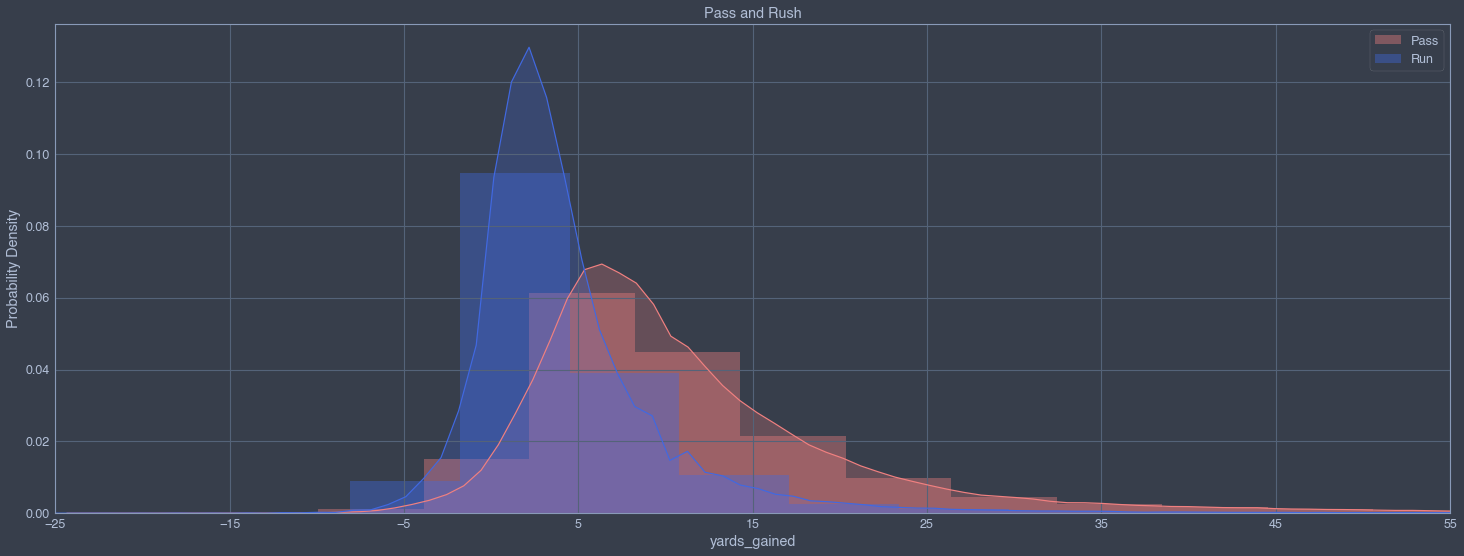

In [135]:
df_pass = df[(df.play_type == 'pass') & (df.complete_pass == 1)].copy()
df_run = df[df.play_type == 'run'].copy()

fig, ax = plt.subplots(figsize=(25,9))
sns.distplot(df_pass.yards_gained, bins=20, kde_kws=dict(shade=True), kde=True, color=C[0],
             ax=ax, label='Pass')
sns.distplot(df_run.yards_gained, bins=20, kde_kws=dict(shade=True), kde=True, color=C[1],
             ax=ax, label='Run')
plt.xlim(-5, 10)
plt.xticks(range(-25, 65, 10))
plt.legend(loc=0)
plt.ylabel('Probability Density')
plt.title('Pass and Rush')
plt.show();

Ну а тут все примерно одинаково

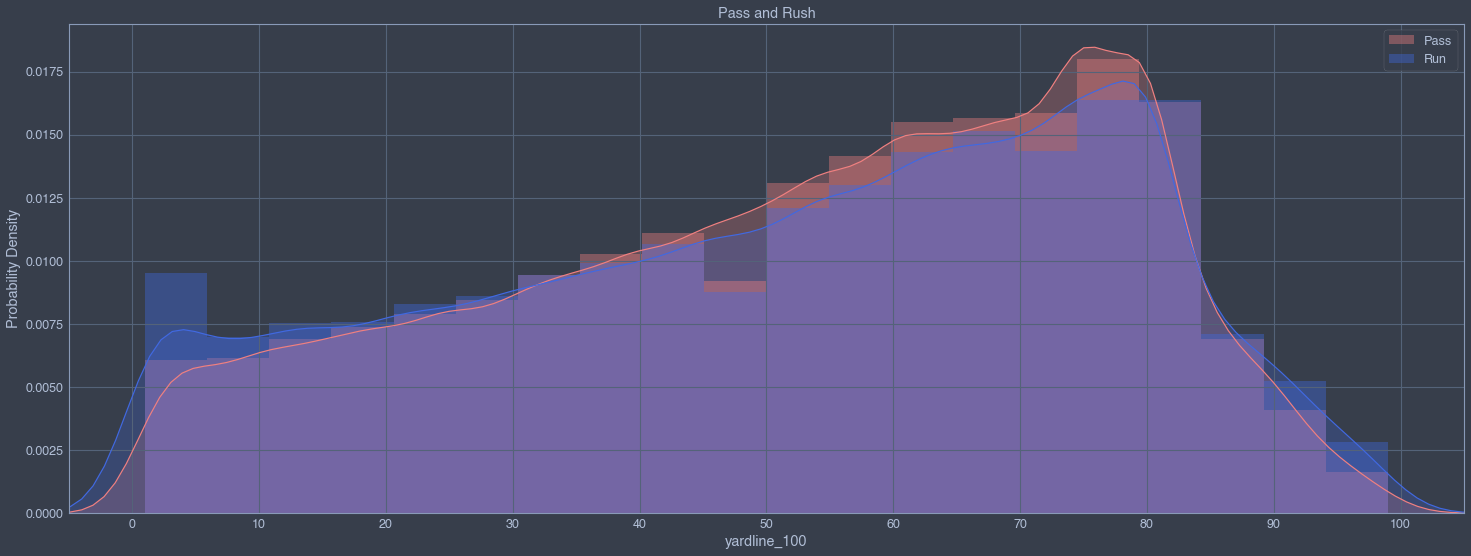

In [137]:
df_pass = df[(df.play_type == 'pass')].copy()
df_run = df[df.play_type == 'run'].copy()

fig, ax = plt.subplots(figsize=(25,9))
sns.distplot(df_pass.yardline_100, bins=20, kde_kws=dict(shade=True), kde=True, color=C[0],
             ax=ax, label='Pass')
sns.distplot(df_run.yardline_100, bins=20, kde_kws=dict(shade=True), kde=True, color=C[1],
             ax=ax, label='Run')
plt.xlim(-5, 105)
plt.xticks(range(0, 101, 10))
plt.legend(loc=0)
plt.ylabel('Probability Density')
plt.title('Pass and Rush')
plt.show();

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317748 entries, 0 to 317747
Data columns (total 61 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     317748 non-null  int64  
 1   game_id                     317748 non-null  int64  
 2   posteam                     317748 non-null  object 
 3   posteam_type                317748 non-null  object 
 4   defteam                     317748 non-null  object 
 5   yardline_100                317748 non-null  float64
 6   half_seconds_remaining      317748 non-null  float64
 7   game_seconds_remaining      317748 non-null  float64
 8   game_date                   317748 non-null  object 
 9   drive                       317748 non-null  int64  
 10  qtr                         317748 non-null  int64  
 11  down                        317748 non-null  float64
 12  yrdln                       317748 non-null  object 
 13  ydstogo       

In [97]:
df['def_dvoa'] = df['def_dvoa'].str.rstrip('%').astype('float') / 100
df['def_pass'] = df['def_pass'].str.rstrip('%').astype('float') / 100
df['def_run'] = df['def_run'].str.rstrip('%').astype('float') / 100
df['off_dvoa'] = df['off_dvoa'].str.rstrip('%').astype('float') / 100
df['off_pass'] = df['off_pass'].str.rstrip('%').astype('float') / 100
df['off_run'] = df['off_run'].str.rstrip('%').astype('float') / 100

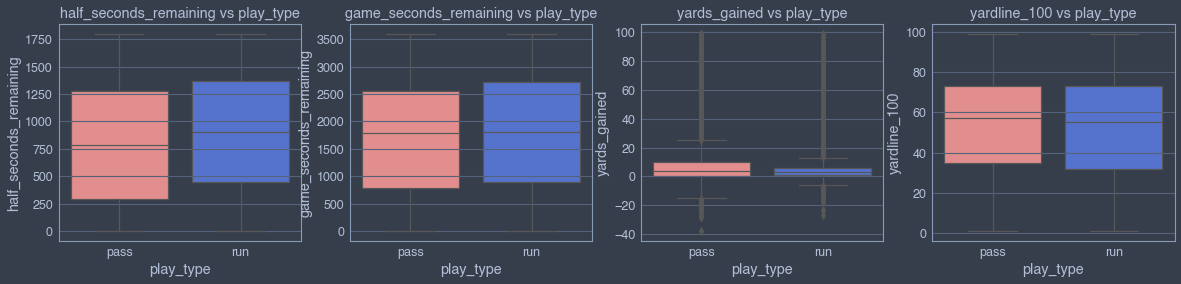

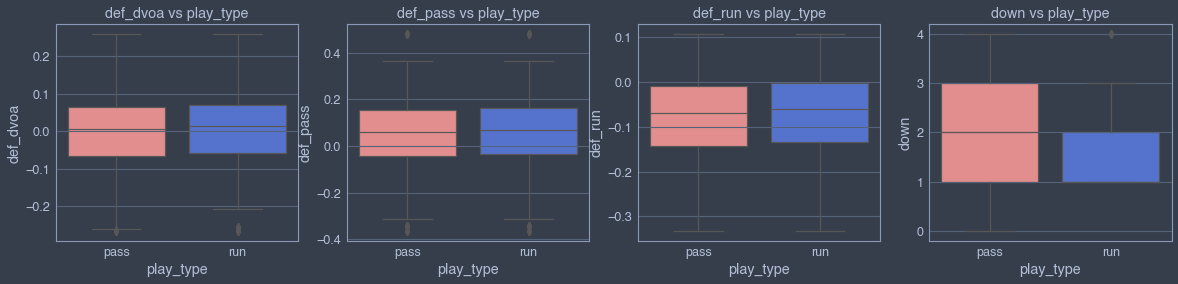

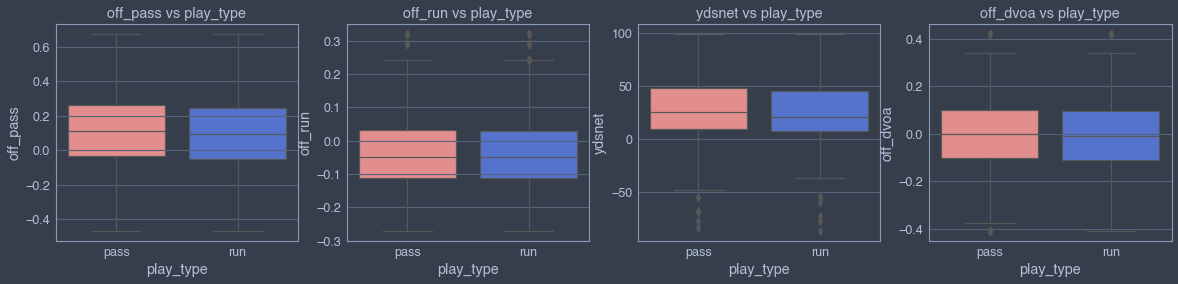

In [98]:
##Ага, у yards_gained слишком длинный хвоест
target = "play_type"
graphs_per_row = 4
cols = ['yardline_100','half_seconds_remaining','game_seconds_remaining','yards_gained','down','def_dvoa','def_pass','def_run',
        'off_dvoa','off_pass','off_run','ydsnet','play_type']

df_stat = pd.DataFrame()
for col in cols:
    df_stat[col] = df[col]

data = df_stat
colors = C

index = graphs_per_row - 1 # нужно чтобы f,axes сработали при первом прохождении цикла
for j in data.drop(target, axis=1).columns.values:
    if ((index % graphs_per_row) == (graphs_per_row - 1)):
        f, axes = plt.subplots(ncols=graphs_per_row, figsize=(20,4))

    sns.boxplot(x=target, y=j, data=data, palette=colors, ax=axes[index % graphs_per_row])
    axes[index % graphs_per_row].set_title(j + " vs " + target)
    index += 1

In [99]:
# выбросим выбросы
# варианты: 
# - границы в абсолютных значениях
# - интерквартильное расстояние (IQR)
# - cреднее-среднеквадратичное отклонение 
# - Медианы абсолютного отклонения (MAD)
# сегодня мне нравится интерквартильное расстояние, хотя на практике стоит перебрать все варианты.
def outlier_detect_IQR(data,col,threshold=3):    
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Количество выбросов в данных:',outlier_index.value_counts()[1])
    print('Доля выбросов:',outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index, para

In [100]:
index,para = outlier_detect_IQR(data=df,col='yards_gained',threshold=3)
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])

Количество выбросов в данных: 5795
Доля выбросов: 0.018237722975439657
Верхняя граница: 32.0 
Нижняя граница: -24.0


In [101]:
index.sum()

5795

In [102]:
index[index].index

Int64Index([    57,     59,    234,    263,    321,    340,    405,    431,
               433,    442,
            ...
            317108, 317208, 317289, 317297, 317389, 317483, 317541, 317560,
            317608, 317644],
           dtype='int64', length=5795)

In [103]:
df.shape
df.drop(index[index].index, inplace = True)

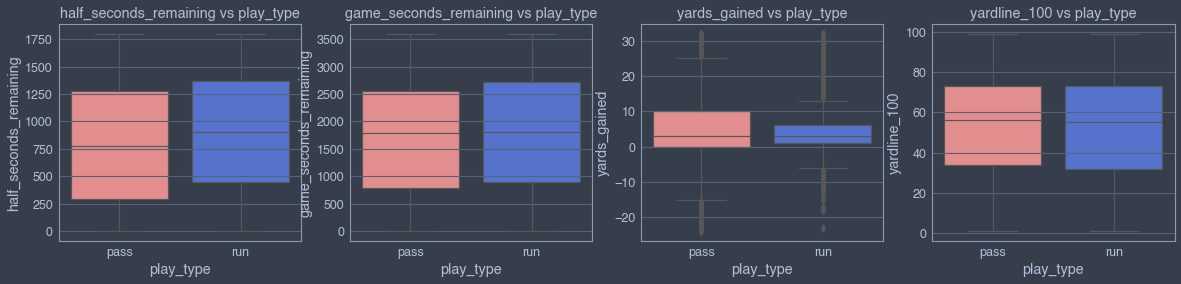

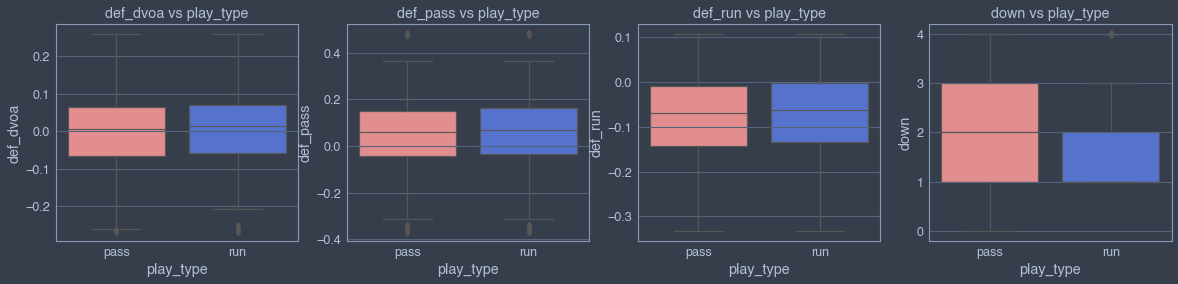

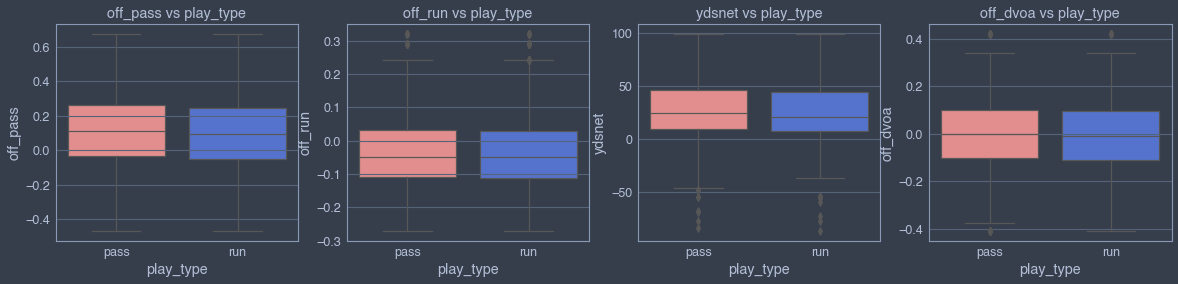

In [104]:
target = "play_type"
graphs_per_row = 4
cols = ['yardline_100','half_seconds_remaining','game_seconds_remaining','yards_gained','down','def_dvoa','def_pass','def_run',
        'off_dvoa','off_pass','off_run','ydsnet','play_type']

df_stat = pd.DataFrame()
for col in cols:
    df_stat[col] = df[col]

data = df_stat
colors = C

index = graphs_per_row - 1 # нужно чтобы f,axes сработали при первом прохождении цикла
for j in data.drop(target, axis=1).columns.values:
    if ((index % graphs_per_row) == (graphs_per_row - 1)):
        f, axes = plt.subplots(ncols=graphs_per_row, figsize=(20,4))

    sns.boxplot(x=target, y=j, data=data, palette=colors, ax=axes[index % graphs_per_row])
    axes[index % graphs_per_row].set_title(j + " vs " + target)
    index += 1

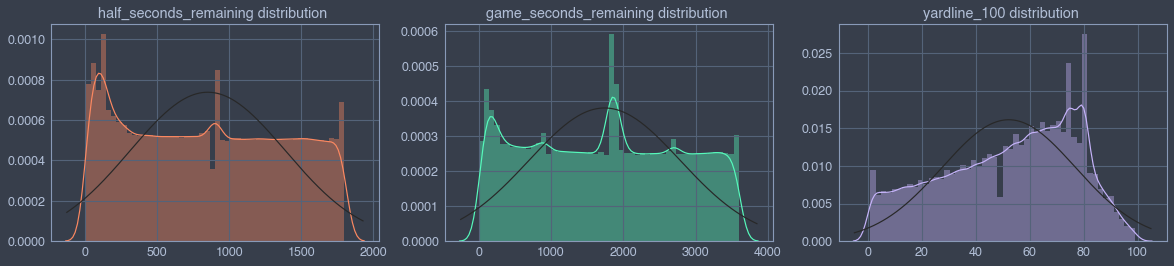

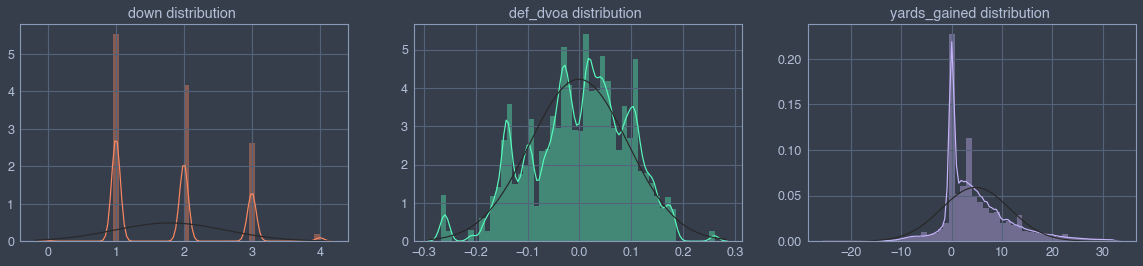

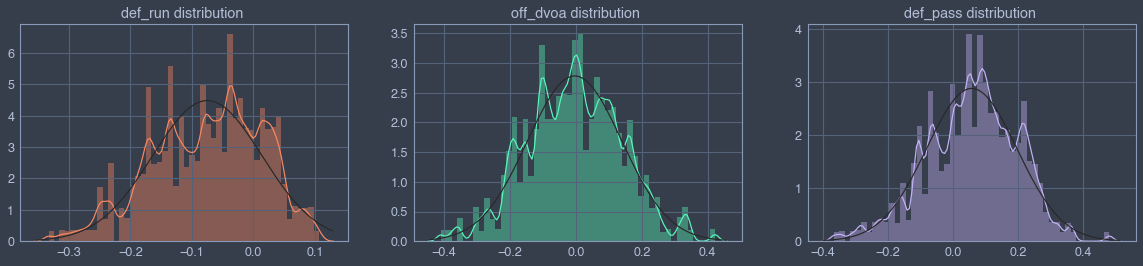

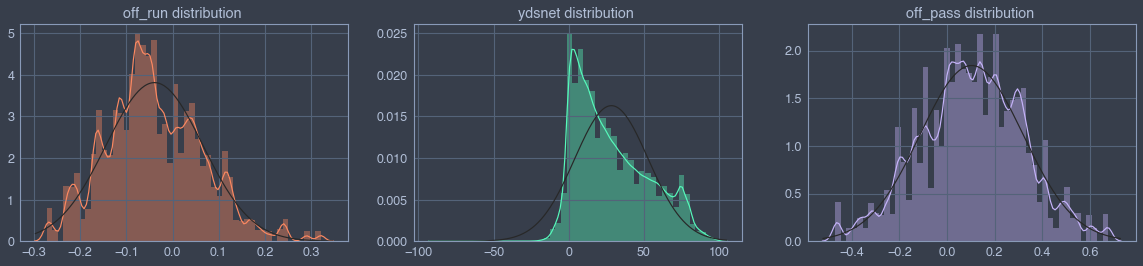

In [105]:
# посмотрим на распределение каждого признака кроме target'a:
from scipy.stats import norm

target = "play_type"
graphs_per_row = 3
data = df_stat
colors = ["#FB8861", "#56F9BB", "#C5B3F9","#FACE8D"] # 

index = graphs_per_row - 1 # нужно чтобы f,axes сработали при первом прохождении цикла
for j in data.drop(target, axis=1).columns.values:
    if ((index % graphs_per_row) == (graphs_per_row - 1)):
        f, axes = plt.subplots(ncols=graphs_per_row, figsize=(20,4))

    sns.distplot(data[j].values, ax=axes[index % graphs_per_row], fit=norm, color=colors[index % graphs_per_row])
    axes[index % graphs_per_row].set_title(j + " distribution ")
    index += 1

Посмотрим на тендеции трех разных команд за 10 сезонов

/Users/aleksandrbagdasarov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



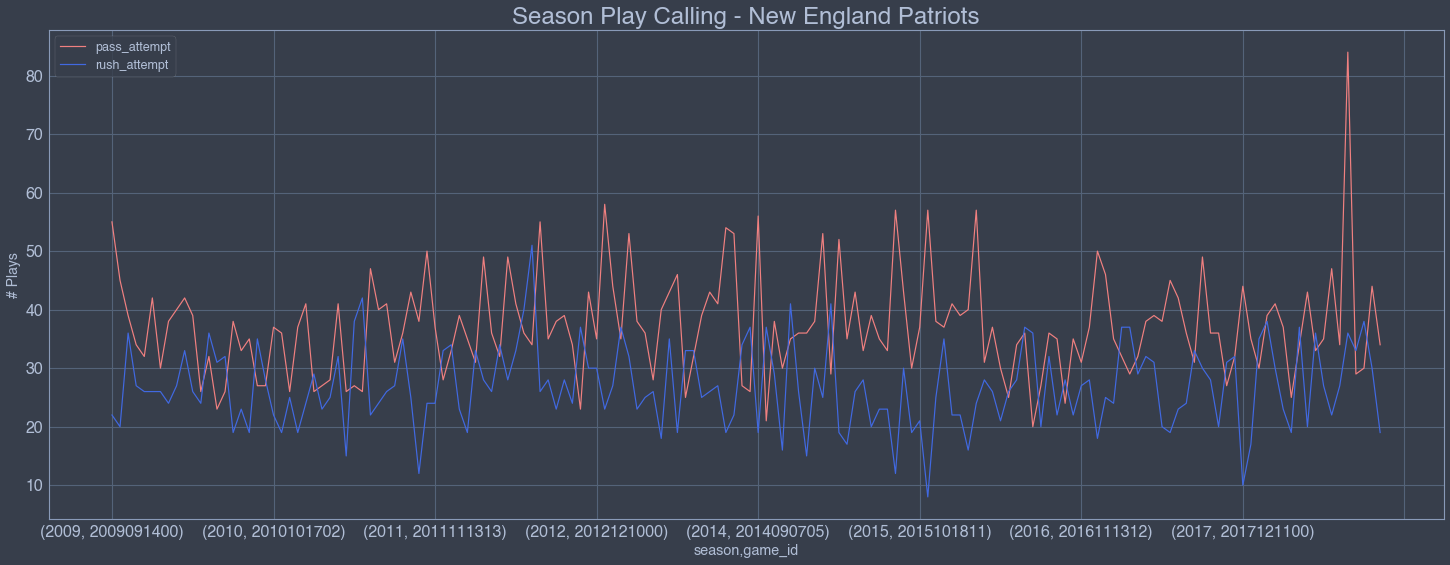

In [106]:
plays_down = df[(df.down <= 3) & (df.qtr < 5) & (df.posteam == 'NE')]
ax = plays_down.groupby(['season','game_id'])['pass_attempt','rush_attempt'].sum().plot.line(color=['lightcoral','royalblue'],figsize=(25,9),rot=0,fontsize=16)
ax.set_title("Season Play Calling - New England Patriots", fontsize=24)
ax.set_ylabel("# Plays", fontsize=14)
ax.set_alpha(0.8)

/Users/aleksandrbagdasarov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



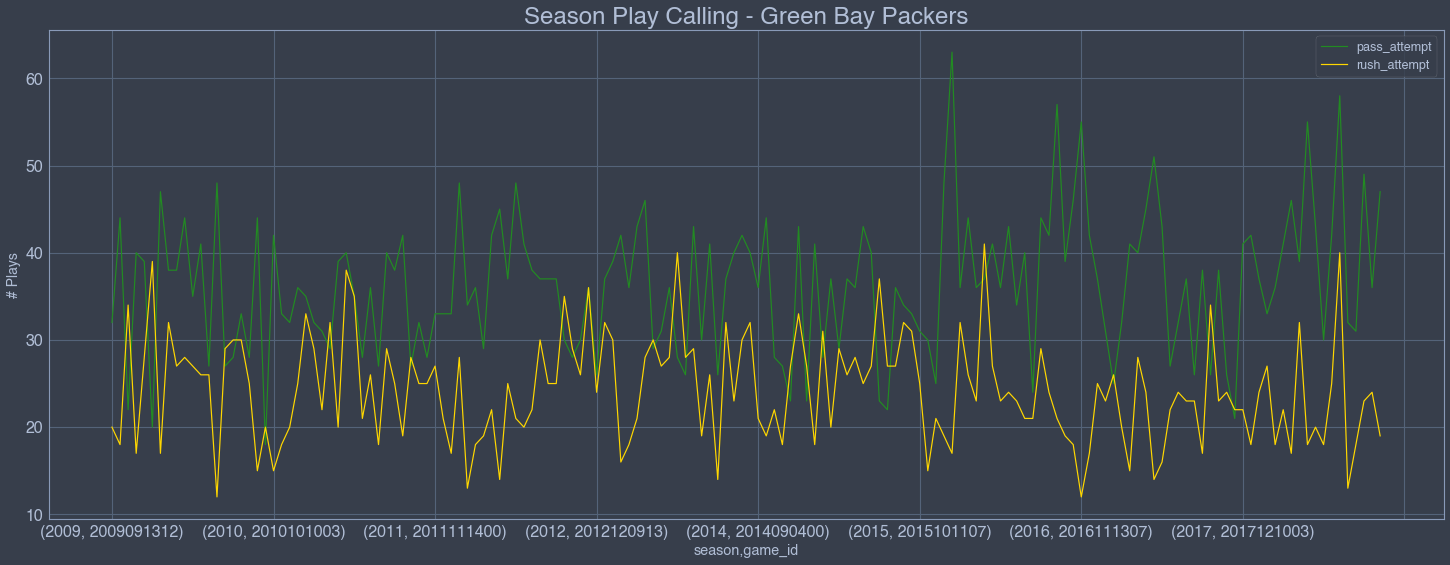

In [107]:
plays_down = df[(df.down <= 3) & (df.qtr < 5) & (df.posteam == 'GB')]
ax = plays_down.groupby(['season','game_id'])['pass_attempt','rush_attempt'].sum().plot.line(color=['forestgreen','gold'],figsize=(25,9),rot=0,fontsize=16)
ax.set_title("Season Play Calling - Green Bay Packers", fontsize=24)
ax.set_ylabel("# Plays", fontsize=14)
ax.set_alpha(0.8)

/Users/aleksandrbagdasarov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



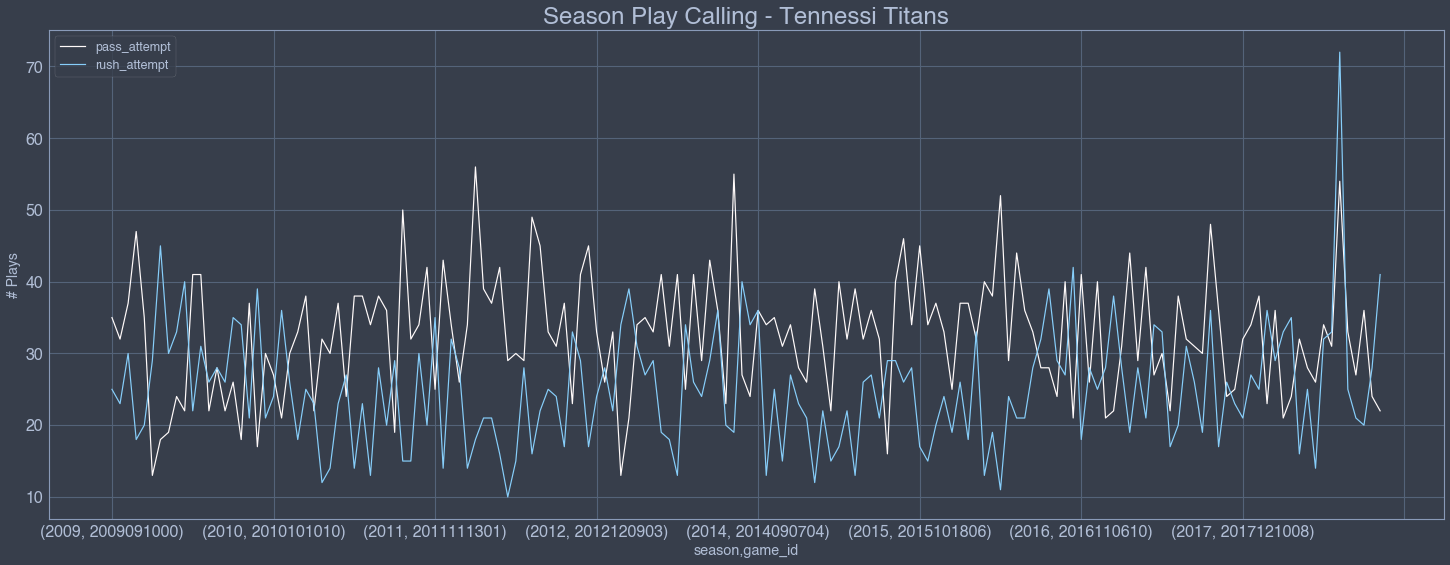

In [108]:
plays_down = df[(df.down <= 3) & (df.qtr < 5) & (df.posteam == 'TEN')]
ax = plays_down.groupby(['season','game_id'])['pass_attempt','rush_attempt'].sum().plot.line(color=['snow','lightskyblue'],figsize=(25,9),rot=0,fontsize=16)
ax.set_title("Season Play Calling - Tennessi Titans", fontsize=24)
ax.set_ylabel("# Plays", fontsize=14)
ax.set_alpha(0.8)

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311953 entries, 0 to 317747
Data columns (total 61 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   play_id                     311953 non-null  int64  
 1   game_id                     311953 non-null  int64  
 2   posteam                     311953 non-null  object 
 3   posteam_type                311953 non-null  object 
 4   defteam                     311953 non-null  object 
 5   yardline_100                311953 non-null  float64
 6   half_seconds_remaining      311953 non-null  float64
 7   game_seconds_remaining      311953 non-null  float64
 8   game_date                   311953 non-null  object 
 9   drive                       311953 non-null  int64  
 10  qtr                         311953 non-null  int64  
 11  down                        311953 non-null  float64
 12  yrdln                       311953 non-null  object 
 13  ydstogo       

In [110]:
#отныне 1 - pass
#0 - run
df['play_type'] = df['play_type'].apply(lambda x: 1 if x=='pass' else 0)
# 0 - away team
# 1 - home team
df['posteam_type'] = df['posteam_type'].apply(lambda x: 1 if x=='away' else 0)

Несмотря на то, что я потратил 2 недели на вычищение этих данных, мне придется их удалить. Все из-за того, что часть из них избыточна, а вот другая часть несет в себе уже информацию о том, как розыгрыш был. Иными словами, это информация из будущего, которую знать перед розыгрышом мы не можем

In [111]:
droplist = ['rush_attempt','pass_attempt','run_gap_center','pass_touchdown','defteam','posteam','game_date','game_id','drive','play_id','yrdln','desc',
           'run_gap_end','run_gap_guard','run_gap_tackle','run_loc_left','run_loc_middle','run_loc_right','pass_loc_left','pass_loc_middle','pass_loc_right','pass_len_deep','pass_len_short',
           'incomplete_pass','complete_pass','interception','first_down_pass','first_down_rush','sack','safety','no_huddle']

df = df.drop(droplist, axis=1)

In [112]:
df['season'] = df['season'].astype(int)

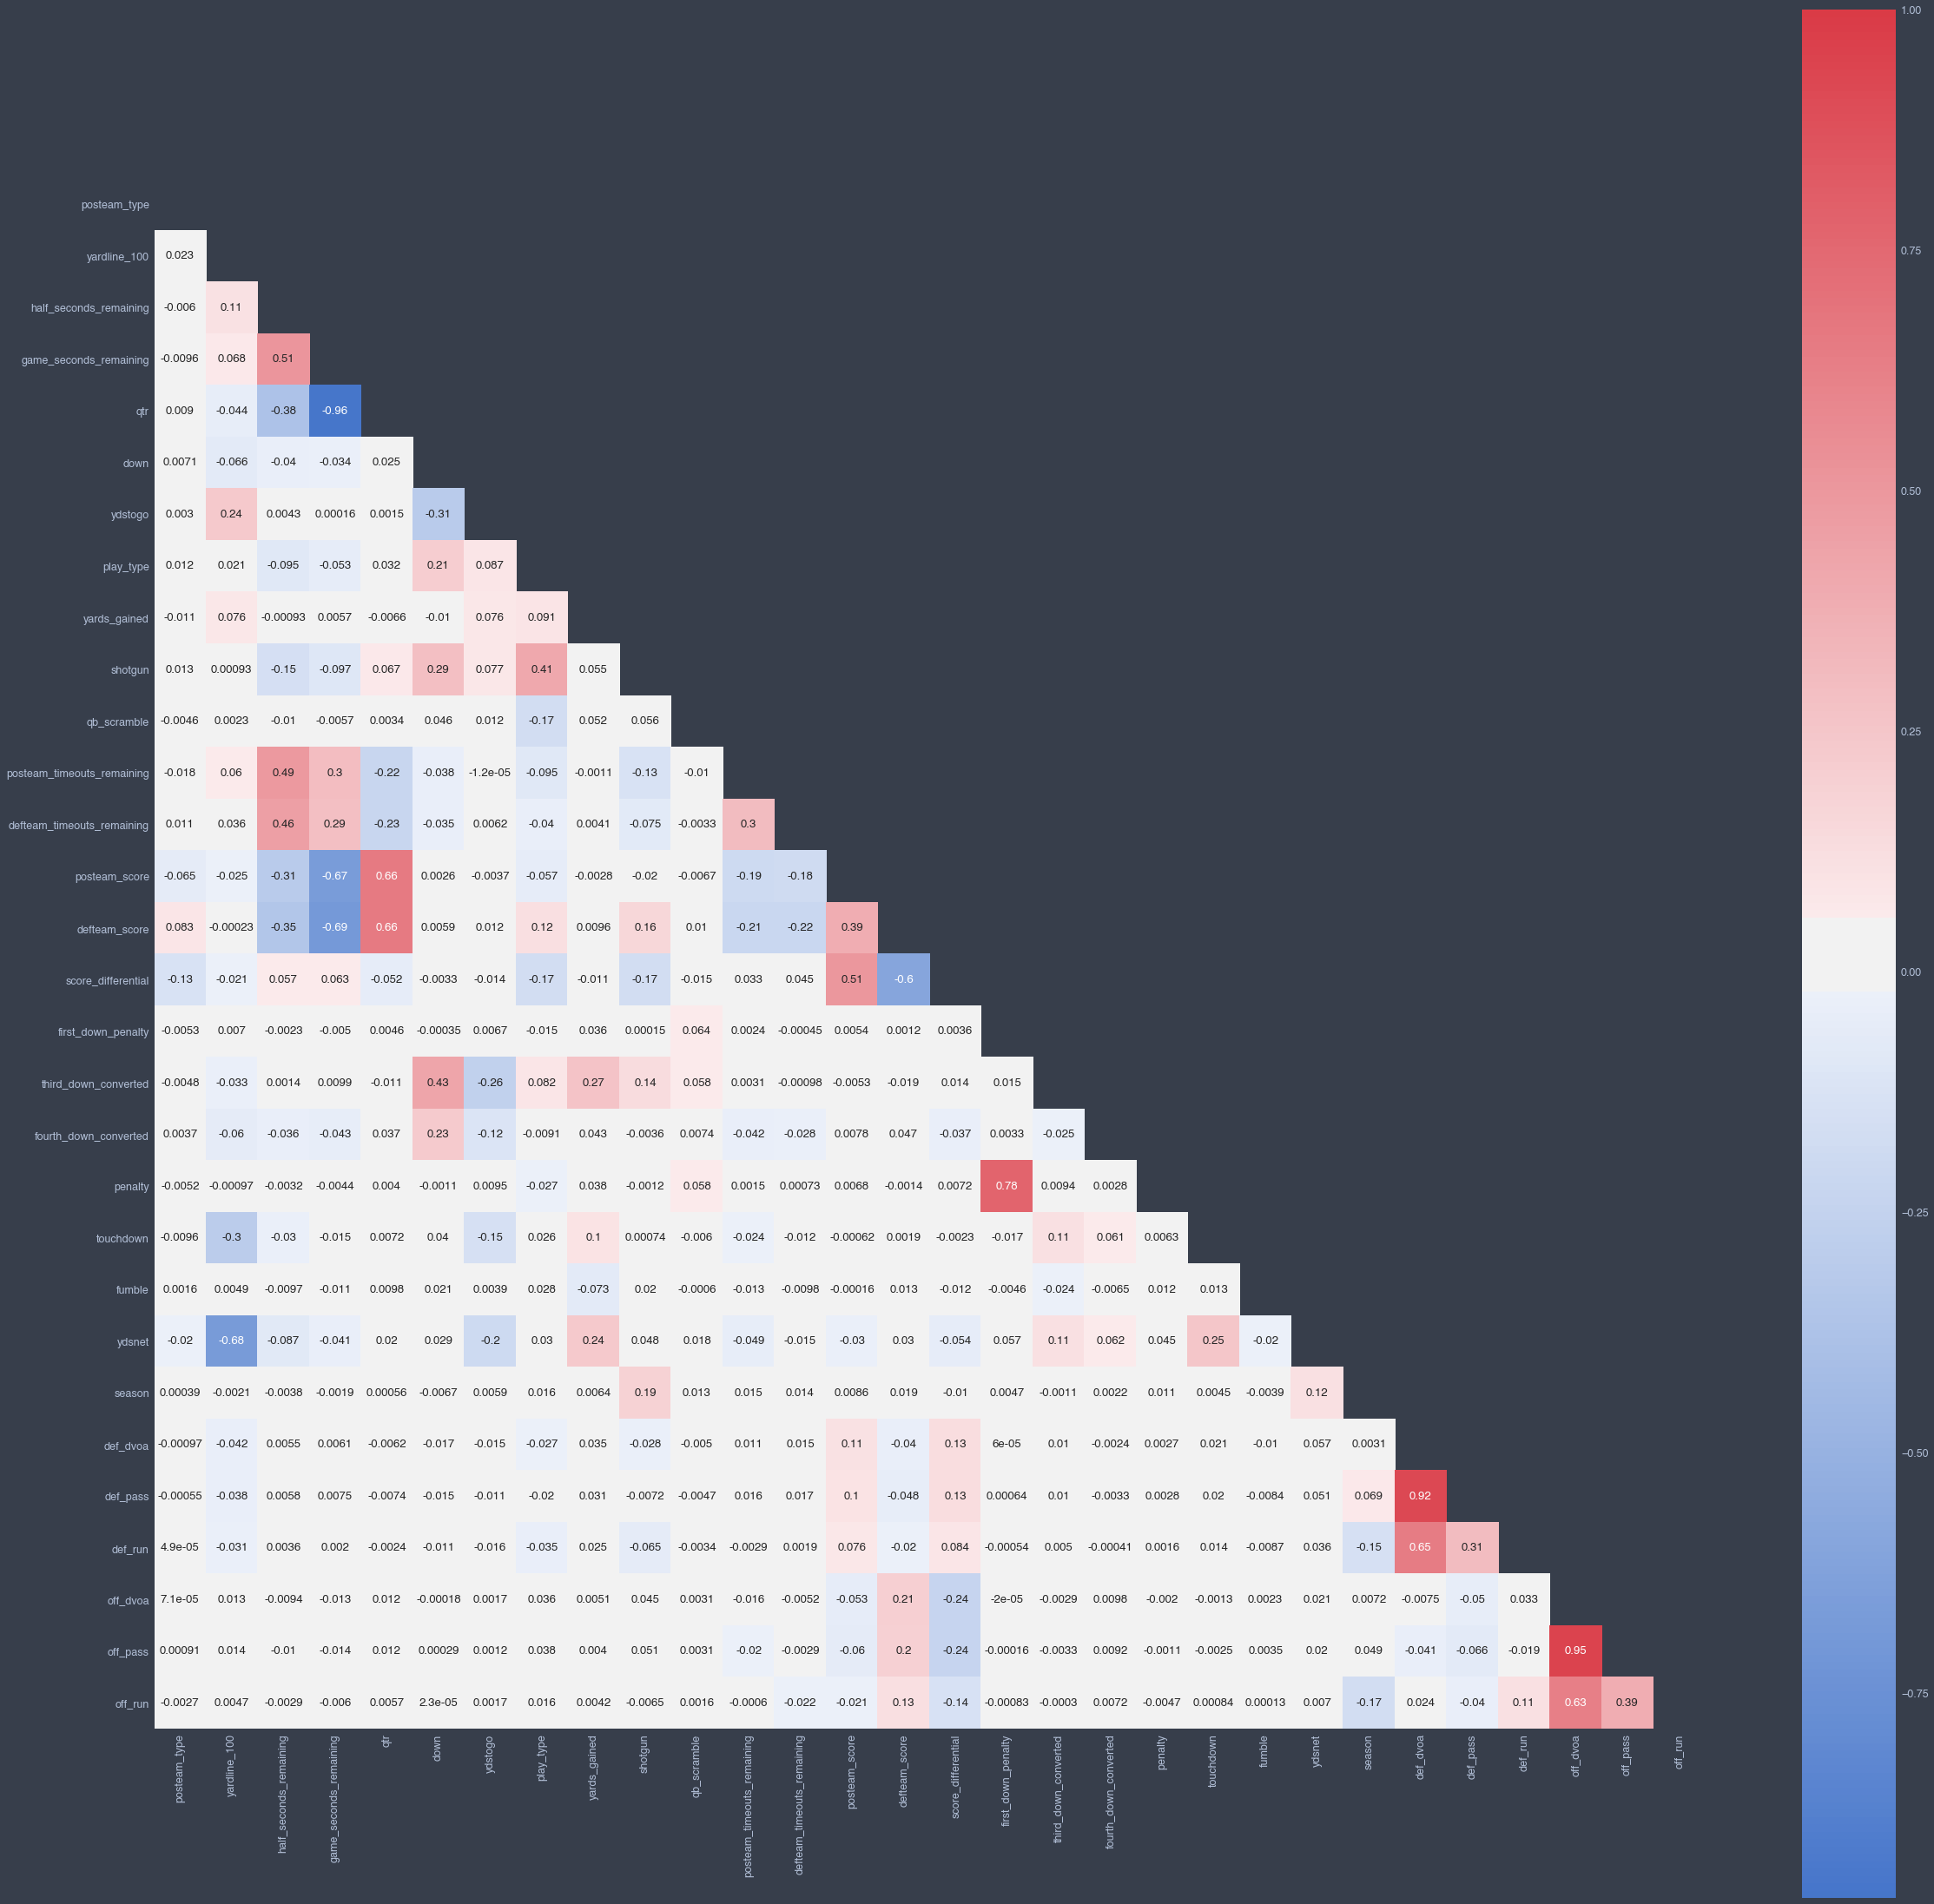

In [113]:
plt.figure(figsize = (40,40))
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(255, 10, as_cmap = True)
sns.heatmap(\
            df.corr(), \
            annot = True, \
            square = True, \
            mask = mask, \
            cmap = cmap \
).get_figure().savefig("correlations_big_picture.png");

In [114]:
df.to_csv('data/pre model.csv', index=False)

In [115]:
df = pd.read_csv('data/pre model.csv')
df

,posteam_type,yardline_100,half_seconds_remaining,game_seconds_remaining,qtr,down,ydstogo,play_type,yards_gained,shotgun,qb_scramble,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_penalty,third_down_converted,fourth_down_converted,penalty,touchdown,fumble,ydsnet,season,def_dvoa,def_pass,def_run,off_dvoa,off_pass,off_run
0,0,58.0,1793.0,3593.0,1,1.0,10,1,5.0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2009,0.091,0.134,0.031,0.042,0.088,0.084
1,0,53.0,1756.0,3556.0,1,2.0,5,0,-3.0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2009,0.091,0.134,0.031,0.042,0.088,0.084
2,0,56.0,1715.0,3515.0,1,3.0,8,1,0.0,1,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2009,0.091,0.134,0.031,0.042,0.088,0.084
3,1,98.0,1696.0,3496.0,1,1.0,10,0,0.0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2009,-0.046,0.018,-0.139,0.144,0.345,-0.026
4,1,98.0,1660.0,3460.0,1,2.0,10,1,4.0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2009,-0.046,0.018,-0.139,0.144,0.345,-0.026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311948,0,71.0,82.0,82.0,4,2.0,1,1,0.0,1,0,0.0,1.0,7.0,12.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,19,2018,-0.029,0.106,-0.249,0.159,0.345,0.033
311949,0,71.0,77.0,77.0,4,3.0,1,1,5.0,1,0,0.0,1.0,7.0,12.0,-5.0,0.0,1.0,0.0,0.0,0.0,0.0,19,2018,-0.029,0.106,-0.249,0.159,0.345,0.033
311950,0,66.0,63.0,63.0,4,2.0,10,1,0.0,1,0,0.0,1.0,7.0,12.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,19,2018,-0.029,0.106,-0.249,0.159,0.345,0.033
311951,0,66.0,58.0,58.0,4,3.0,10,1,5.0,1,0,0.0,1.0,7.0,12.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,19,2018,-0.029,0.106,-0.249,0.159,0.345,0.033


## Modeling

In [116]:
C = ['lightcoral','royalblue','forestgreen','gold','#FB8861','#56F9BB','#C5B3F9','#FACE8D']

In [117]:
def quality_report(actual, prediction):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(actual, prediction),
        precision_score(actual, prediction),
        recall_score(actual, prediction),
        f1_score(actual, prediction)
    ))
    

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(figsize=(25, 18))
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

In [118]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['play_type'], axis=1), df['play_type'], test_size=0.30, random_state=42, stratify=df["play_type"])

#standardization 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Accuracy: 0.485
Precision: 0.415
Recall: 0.582
f1_score: 0.485


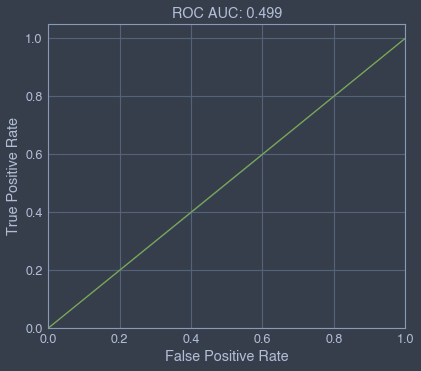

In [119]:
y_naive = np.random.choice([0, 1], size=y_test.shape[0], p=y_train.value_counts(normalize=True))

quality_report(y_naive, y_test)

plot_roc_curve(y_naive, y_test)

### Logistic Regression

In [120]:
log_reg = LogisticRegression()

log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Train quality
Accuracy: 0.736
Precision: 0.777
Recall: 0.768
f1_score: 0.772

Test quality
Accuracy: 0.738
Precision: 0.778
Recall: 0.771
f1_score: 0.774


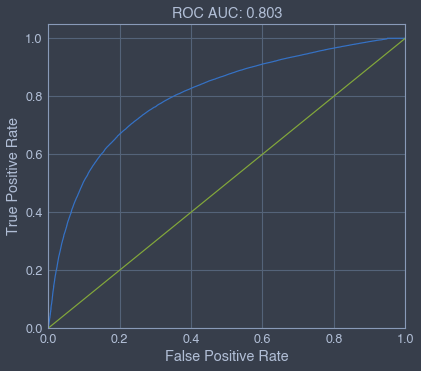

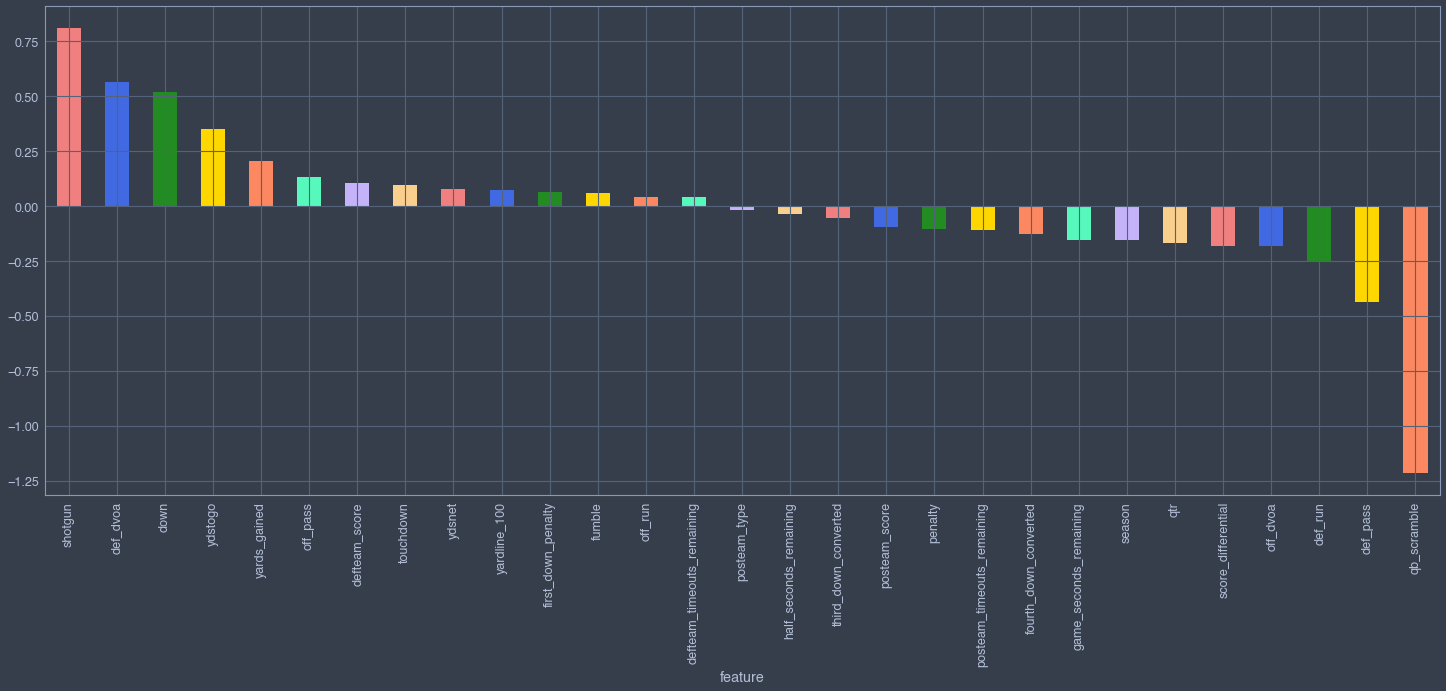

In [121]:
print("Train quality")
quality_report(y_train, log_reg.predict(X_train_scaled))

print("\nTest quality")
quality_report(y_test, log_reg.predict(X_test_scaled))

plot_roc_curve(log_reg.predict_proba(X_test_scaled)[:, 1], y_test)

featureImportance = pd.DataFrame({"feature": df.drop('play_type',axis=1).columns, 
                                  "importance": log_reg.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar',figsize=(25,9),color=C);

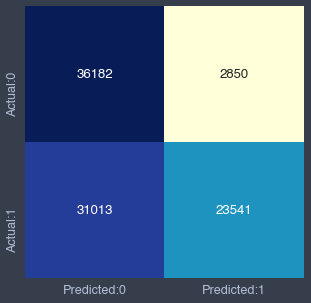

In [122]:
cm = confusion_matrix(y_test, log_reg.predict_proba(X_test_scaled)[:, 1]>0.8)

conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

### Support Vector Machine

In [17]:
%%time
svm = SVC()

svm.fit(X_train_scaled, y_train)

CPU times: user 59min, sys: 169 ms, total: 59min
Wall time: 59min


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [18]:
%%time
print("Train quality")
quality_report(y_train, svm.predict(X_train_scaled))

print("\nTest quality")
quality_report(y_test, svm.predict(X_test_scaled))

Train quality
Accuracy: 0.761
Precision: 0.797
Recall: 0.792
f1_score: 0.794

Test quality
Accuracy: 0.755
Precision: 0.792
Recall: 0.787
f1_score: 0.789
CPU times: user 29min 30s, sys: 55.9 ms, total: 29min 30s
Wall time: 29min 30s


In [19]:
%%time
svm = SVC(probability=True)

svm.fit(X_train_scaled, y_train)

CPU times: user 6h 18min 18s, sys: 1.66 s, total: 6h 18min 20s
Wall time: 6h 18min 21s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Train quality
Accuracy: 0.761
Precision: 0.797
Recall: 0.792
f1_score: 0.794

Test quality
Accuracy: 0.755
Precision: 0.792
Recall: 0.787
f1_score: 0.789


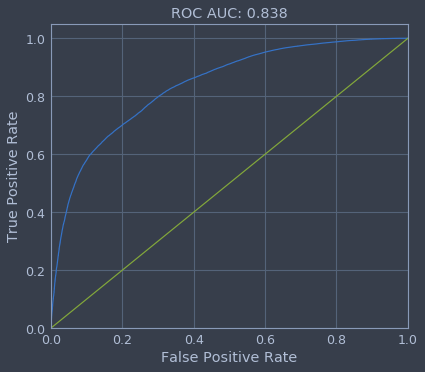

CPU times: user 38min 27s, sys: 432 ms, total: 38min 28s
Wall time: 38min 31s


In [25]:
%%time
print("Train quality")
quality_report(y_train, svm.predict(X_train_scaled))

print("\nTest quality")
quality_report(y_test, svm.predict(X_test_scaled))

plot_roc_curve(svm.predict_proba(X_test_scaled)[:, 1], y_test)

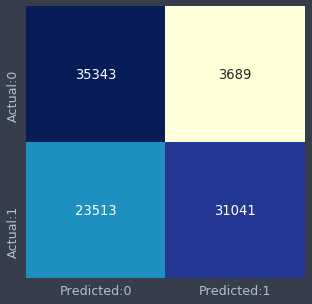

In [24]:
cm = confusion_matrix(y_test, svm.predict_proba(X_test_scaled)[:, 1]>0.8)

conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

### XGBoost

In [124]:
from xgboost import XGBClassifier
from xgboost import plot_tree

model = XGBClassifier()
model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [125]:
accuracy_score(y_test, model.predict(X_test_scaled))

0.819684568204646

Train quality
Accuracy: 0.818
Precision: 0.826
Recall: 0.872
f1_score: 0.848

Test quality
Accuracy: 0.820
Precision: 0.827
Recall: 0.873
f1_score: 0.849


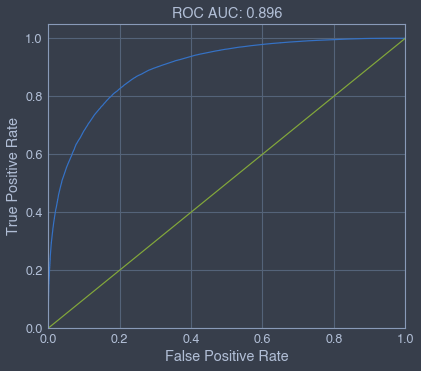

In [126]:
print("Train quality")
quality_report(y_train, model.predict(X_train_scaled))

print("\nTest quality")
quality_report(y_test, model.predict(X_test_scaled))

plot_roc_curve(model.predict_proba(X_test_scaled)[:, 1], y_test)

# featureImportance = pd.DataFrame({"feature": df.drop('play_type',axis=1).columns, 
#                                   "importance": model.coef_[0]})

# featureImportance.set_index('feature', inplace=True)
# featureImportance.sort_values(["importance"], ascending=False, inplace=True)
# featureImportance["importance"].plot(kind='bar',figsize=(25,9), color=C);

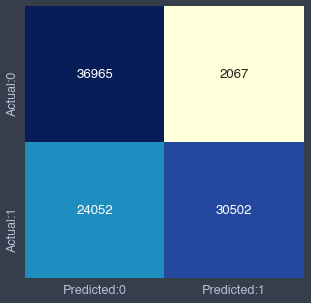

In [127]:
cm = confusion_matrix(y_test, model.predict_proba(X_test_scaled)[:, 1]>0.8)

conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

In [128]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=10, random_state=7, shuffle=True)
results = cross_val_score(model, X_train_scaled, y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 81.73% (0.20%)


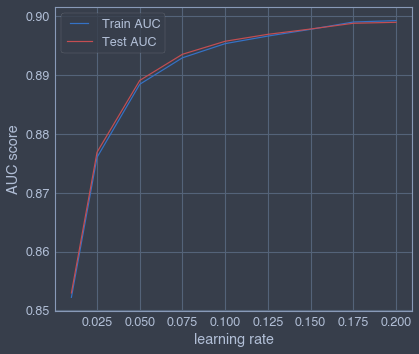

CPU times: user 4min 26s, sys: 692 ms, total: 4min 27s
Wall time: 4min 27s


In [129]:
%%time
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

learning_rates = [0.2, 0.175 ,0.15, 0.125, 0.1, 0.075, 0.05, 0.025, 0.01]

train_results = []
test_results = []
train_results = []
test_results = []

for eta in learning_rates:
    model = XGBClassifier(learning_rate=eta)
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict_proba(X_train_scaled)[:, 1]

#     plot_roc_curve(clf.predict_proba(X_test_scaled)[:, 1], y_test)
#     fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
#     auc_score = roc_auc_score(y_test, prob_prediction)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict_proba(X_test_scaled)[:, 1]

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

# plt.figure(figsize=(25, 18))
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

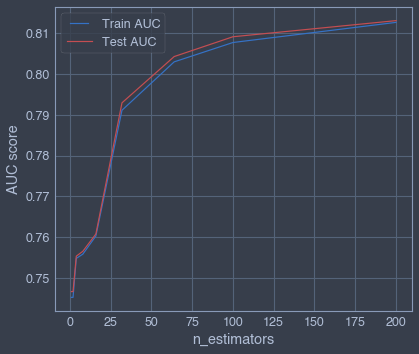

CPU times: user 2min 3s, sys: 450 ms, total: 2min 3s
Wall time: 2min 3s


In [130]:
%%time
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
test_results = []
for estimator in n_estimators:
    model = XGBClassifier(n_estimators=estimator)
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(X_test_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

# plt.figure(figsize=(12, 10))
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

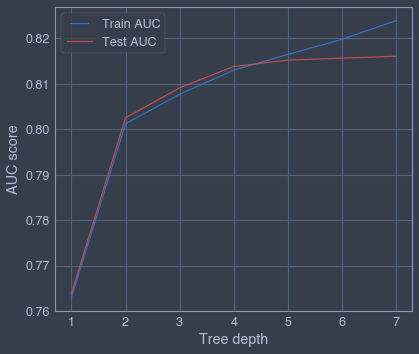

CPU times: user 4min 28s, sys: 471 ms, total: 4min 29s
Wall time: 4min 29s


In [131]:
%%time
max_depths = np.linspace(1, 7, 7, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
    model = XGBClassifier(max_depth=int(max_depth))
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(X_test_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

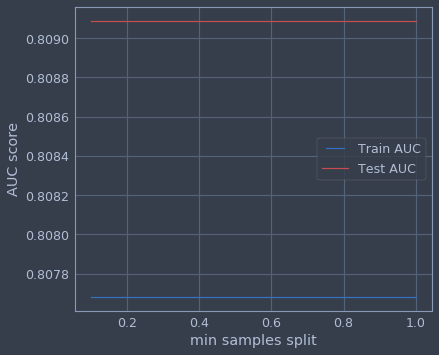

CPU times: user 2min 32s, sys: 608 ms, total: 2min 33s
Wall time: 2min 33s


In [149]:
%%time
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    model = XGBClassifier(min_samples_split=min_samples_split)
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(X_test_scaled)


    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

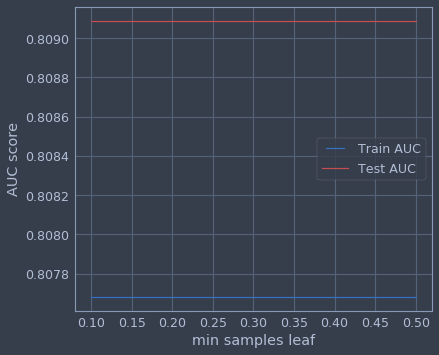

CPU times: user 1min 19s, sys: 496 ms, total: 1min 20s
Wall time: 1min 21s


In [148]:
%%time
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    model = XGBClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(X_test_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

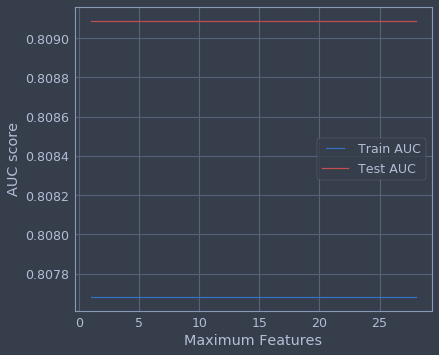

CPU times: user 7min 25s, sys: 2.04 s, total: 7min 27s
Wall time: 7min 28s


In [147]:
%%time
X = df.drop(['play_type'], axis=1)

max_features = list(range(1,X.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    model = XGBClassifier(max_features=max_feature)
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(X_test_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Maximum Features')
plt.show()

### Gradient Boosting

In [114]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier().fit(X_train_scaled, y_train)

Train quality
Accuracy: 0.821
Precision: 0.829
Recall: 0.872
f1_score: 0.850

Test quality
Accuracy: 0.822
Precision: 0.830
Recall: 0.873
f1_score: 0.851


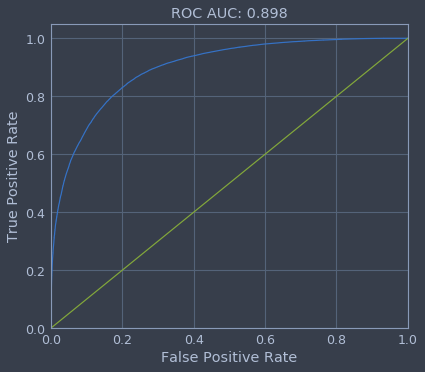

In [115]:
print("Train quality")
quality_report(y_train, clf.predict(X_train_scaled))

print("\nTest quality")
quality_report(y_test, clf.predict(X_test_scaled))

plot_roc_curve(clf.predict_proba(X_test_scaled)[:, 1], y_test)

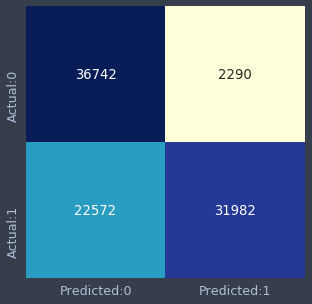

In [116]:
cm = confusion_matrix(y_test, clf.predict_proba(X_test_scaled)[:, 1]>0.8)

conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

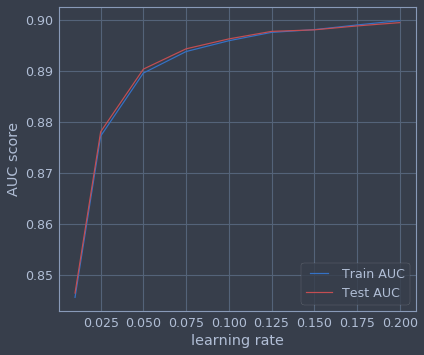

CPU times: user 7min 40s, sys: 62.9 ms, total: 7min 40s
Wall time: 7min 40s


In [123]:
%%time
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

learning_rates = [0.2, 0.175 ,0.15, 0.125, 0.1, 0.075, 0.05, 0.025, 0.01]

train_results = []
test_results = []
train_results = []
test_results = []

for eta in learning_rates:
    clf = GradientBoostingClassifier(learning_rate=eta)
    clf.fit(X_train_scaled, y_train)

    train_pred = clf.predict_proba(X_train_scaled)[:, 1]

#     plot_roc_curve(clf.predict_proba(X_test_scaled)[:, 1], y_test)
#     fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
#     auc_score = roc_auc_score(y_test, prob_prediction)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = clf.predict_proba(X_test_scaled)[:, 1]

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

# plt.figure(figsize=(25, 18))
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

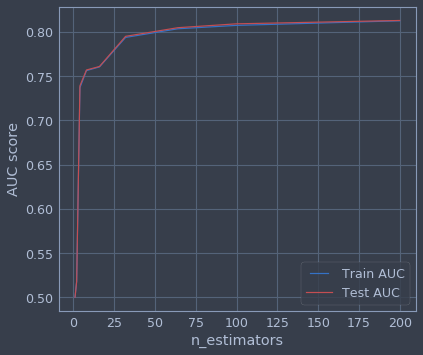

CPU times: user 3min 40s, sys: 23.7 ms, total: 3min 40s
Wall time: 3min 40s


In [124]:
%%time
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
test_results = []
for estimator in n_estimators:
    model = GradientBoostingClassifier(n_estimators=estimator)
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(X_test_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

# plt.figure(figsize=(12, 10))
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

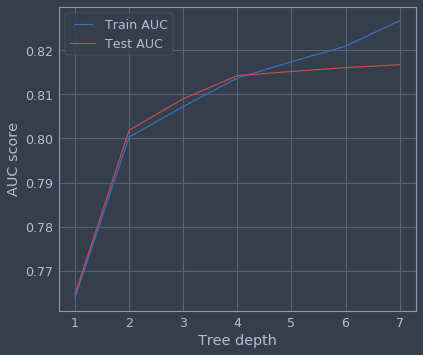

In [132]:
max_depths = np.linspace(1, 7, 7, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(X_test_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()


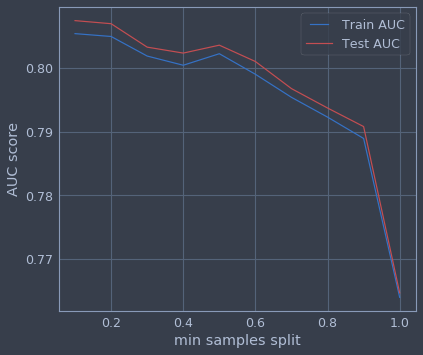

CPU times: user 6min 9s, sys: 71.9 ms, total: 6min 9s
Wall time: 6min 9s


In [136]:
%%time
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    model = GradientBoostingClassifier(min_samples_split=min_samples_split)
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(X_test_scaled)


    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

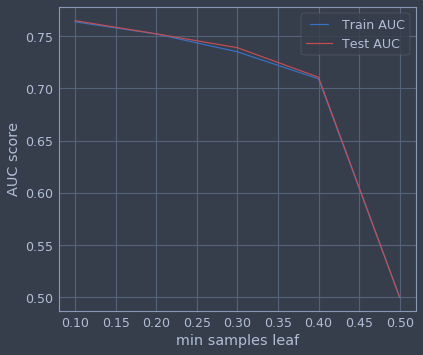

CPU times: user 1min 59s, sys: 3.99 ms, total: 1min 59s
Wall time: 1min 59s


In [137]:
%%time
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(X_test_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

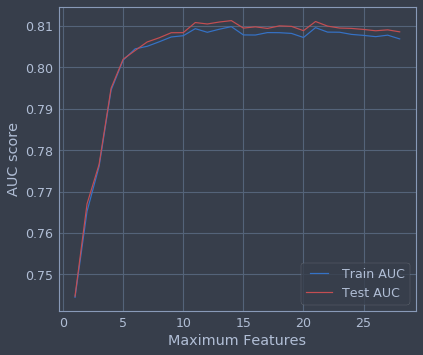

CPU times: user 12min 45s, sys: 27.9 ms, total: 12min 45s
Wall time: 12min 45s


In [139]:
%%time
X = df.drop(['play_type'], axis=1)

max_features = list(range(1,X.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    model = GradientBoostingClassifier(max_features=max_feature)
    model.fit(X_train_scaled, y_train)

    train_pred = model.predict(X_train_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)

    y_pred = model.predict(X_test_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Maximum Features')
plt.show()

## Conclusion

В конечном итоге, лучшей моделькой оказалась XGBoost, мы поигрались с различными гиперпараметрами и выяснили, что большего прироста уже в принципе не получить, так что наш предел 82% точности. Радует то, что за счет большого количества данных и примерно равного соотношения двух типов розыгрышей мы смогли избежать переобучения даже без кросс-валидации. Естественно, для использования в продакшене не хватает многих данных (построение игроков перед розыгрышем, персонал, погода и так далее). В моих планах продолжить ислледование в данном кейсе в двух направлениях:
1. Сбор и добавление дополнительных статистик, которые могли бы нам как-то приблизить данные к реальным условиям
2. Более детально поизучать и повизуализировать данные для нахождения интересных моментов

На этом все. Спасибо за то, что обучали меня и нашил время просмотреть этот проект!